# Project Goals
#### Predict survival of patients following ICU care using clinical data from first 24 hr of ICU admission

## Overview
#### We are using data provided by MIT-led consortium (GOSSIS) from 91,000+ patients, from 200 hospitals in 9 countries.


# The Data: First Look

Let's get our data into a dataframe to examine it:

In [1]:
import src.wrangle
import src.explore
import src.preprocessing
import src.features
import src.model_eval
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc, roc_curve, roc_auc_score, precision_recall_curve

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)
df = src.wrangle.get_raw_data()
data_dict = pd.read_csv('data/WiDS Datathon 2020 Dictionary.csv')

df.head(2)

encounter_id  hospital_id  hospital_death   age    bmi  \
patient_id                                                           
25312              66154          118               0  68.0  22.73   
59342             114252           81               0  77.0  27.42   

            elective_surgery  ethnicity gender  height hospital_admit_source  \
patient_id                                                                     
25312                      0  Caucasian      M   180.3                 Floor   
59342                      0  Caucasian      F   160.0                 Floor   

           icu_admit_source  icu_id icu_stay_type      icu_type  \
patient_id                                                        
25312                 Floor      92         admit         CTICU   
59342                 Floor      90         admit  Med-Surg ICU   

            pre_icu_los_days  readmission_status  weight  albumin_apache  \
patient_id                                                                 
25312               0.541667                   0    73.9             2.3   
59342               0.927778                   0    70.2             NaN   

            apache_2_diagnosis  apache_3j_diagnosis  apache_post_operative  \
patient_id                                                                   
25312                    113.0               502.01                      0   
59342                    108.0               203.01                      0   

            arf_apache  bilirubin_apache  bun_apache  creatinine_apache  \
patient_id                                                                
25312              0.0               0.4        31.0               2.51   
59342              0.0               NaN         9.0               0.56   

            fio2_apache  gcs_eyes_apache  gcs_motor_apache  gcs_unable_apache  \
patient_id                                                                      
25312               NaN              3.0               6.0                0.0   
59342               1.0              1.0               3.0                0.0   

            gcs_verbal_apache  glucose_apache  heart_rate_apache  \
patient_id                                                         
25312                     4.0           168.0              118.0   
59342                     1.0           145.0              120.0   

            hematocrit_apache  intubated_apache  map_apache  paco2_apache  \
patient_id                                                                  
25312                    27.4               0.0        40.0           NaN   
59342                    36.9               0.0        46.0          37.0   

            paco2_for_ph_apache  pao2_apache  ph_apache  resprate_apache  \
patient_id                                                                 
25312                       NaN          NaN        NaN             36.0   
59342                      37.0         51.0       7.45             33.0   

            sodium_apache  temp_apache  urineoutput_apache  ventilated_apache  \
patient_id                                                                      
25312               134.0         39.3                 NaN                0.0   
59342               145.0         35.1                 NaN                1.0   

            wbc_apache  d1_diasbp_invasive_max  d1_diasbp_invasive_min  \
patient_id                                                               
25312             14.1                    46.0                    32.0   
59342             12.7                     NaN                     NaN   

            d1_diasbp_max  d1_diasbp_min  d1_diasbp_noninvasive_max  \
patient_id                                                            
25312                68.0           37.0                       68.0   
59342                95.0           31.0                       95.0   

            d1_diasbp_noninvasive_min  d1_heartrate_max  d1_heartrate_min  \
patient_id                

## Size of the Raw Data

In [2]:
print(f'''Number of Columns: {df.shape[1]}, Number of Rows: {df.shape[0]}''')

Number of Columns: 185, Number of Rows: 91713


> This means that we have *91,713* patients in our dataset, with *185* metrics recorded for each of them within that 24 hour period. That's quite a bit of data.

## Number of Hospitals

In [3]:
print(f'Number of hospitals: {df.hospital_id.nunique()}')

Number of hospitals: 147


## Imbalanced Data

Our goal for this project is to predict patient survivability, so what does that distribution look like in our data?

In [4]:
num_patients_died = len(df[df.hospital_death == 1])
print('Percentage of patients who did not survive: {: .2f}'.format(num_patients_died / len(df)))

Percentage of patients who did not survive:  0.09


>*91* percent of the patients survived their time in the ICU, while only *9* percent did not. 

While this is great news in terms of ICU survival rates, it means we're dealing with an imbalanced dataset which is going to raise its own challenges as we move forward.

## Quick Look at the Missing Values

We'll be using a library called [missingno]('https://github.com/ResidentMario/missingno') to visualize the missing values within the data.

demographic


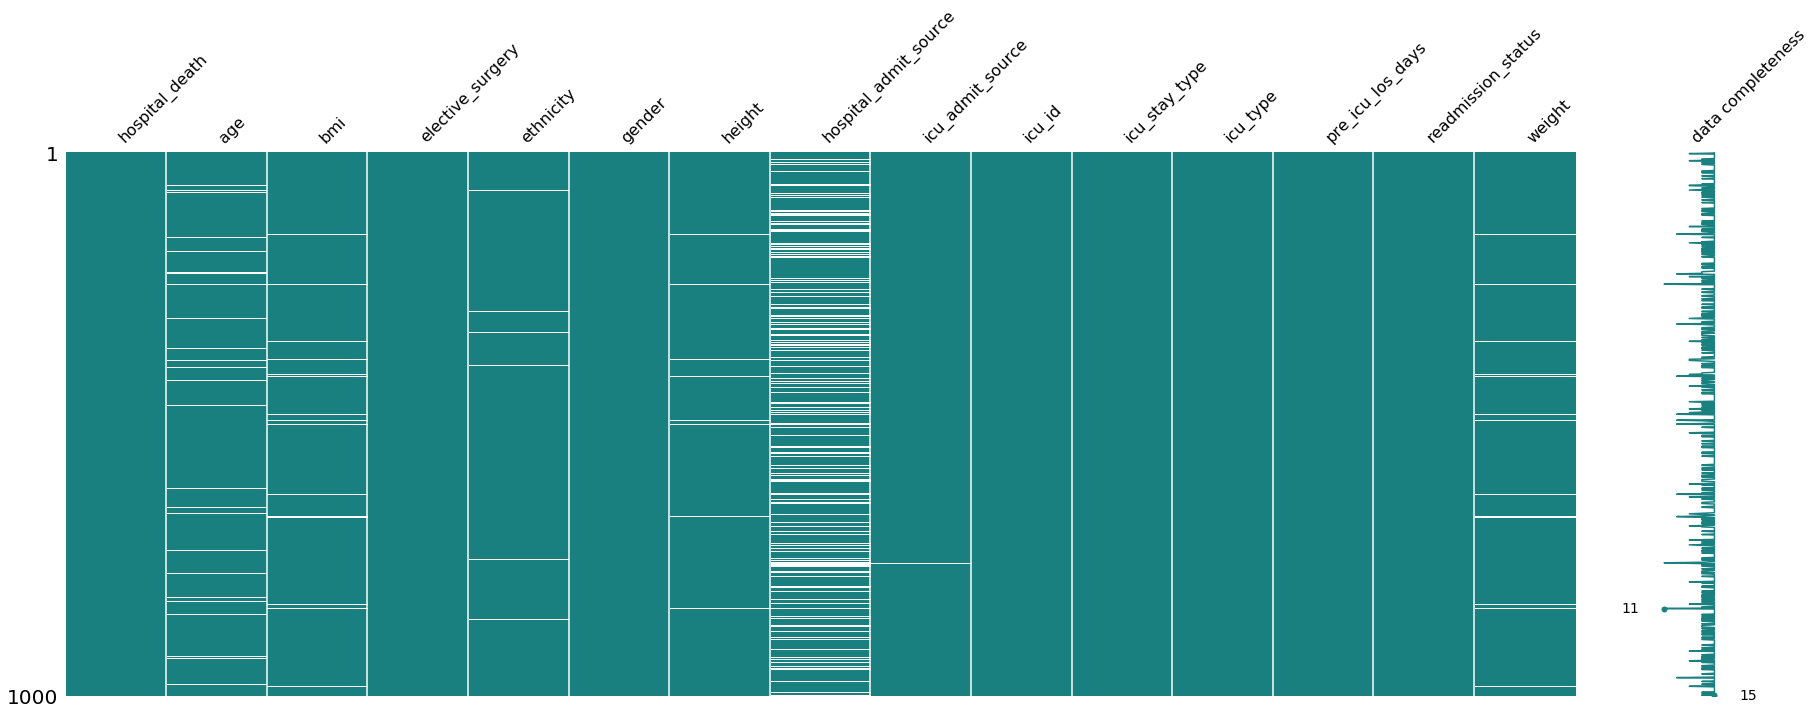

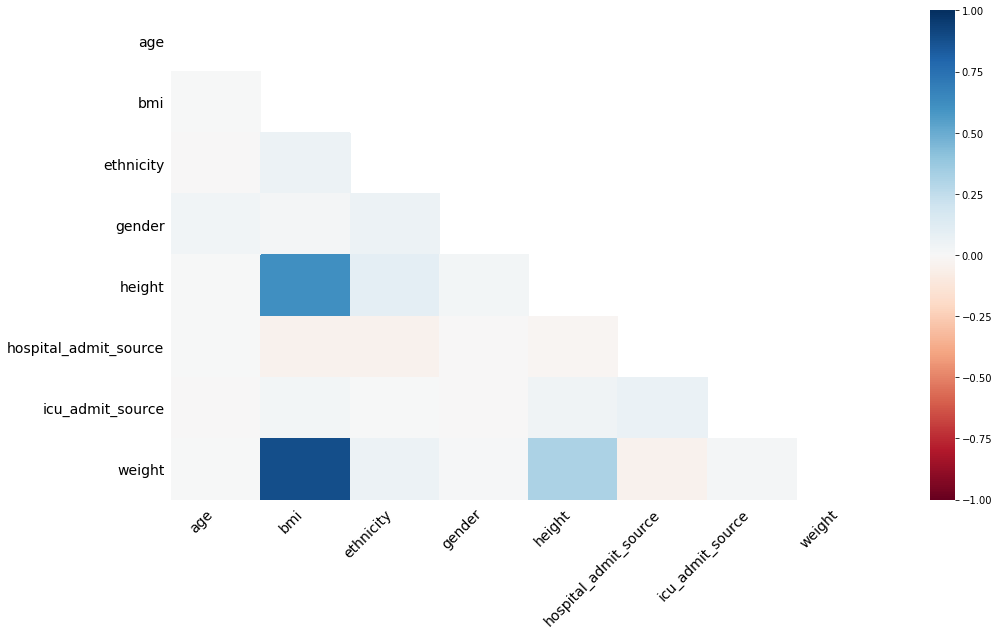

APACHE covariate


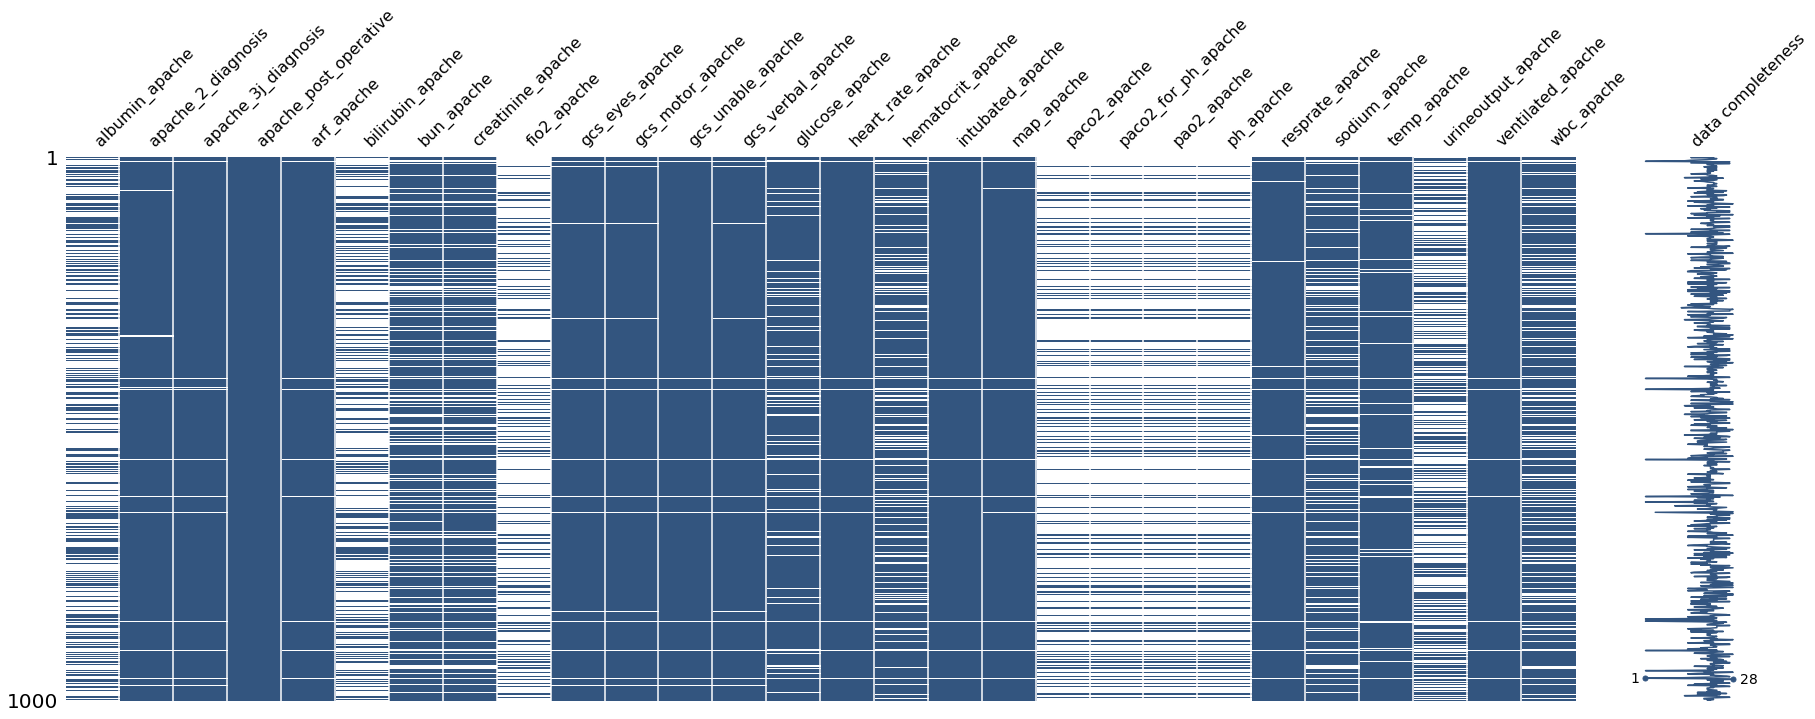

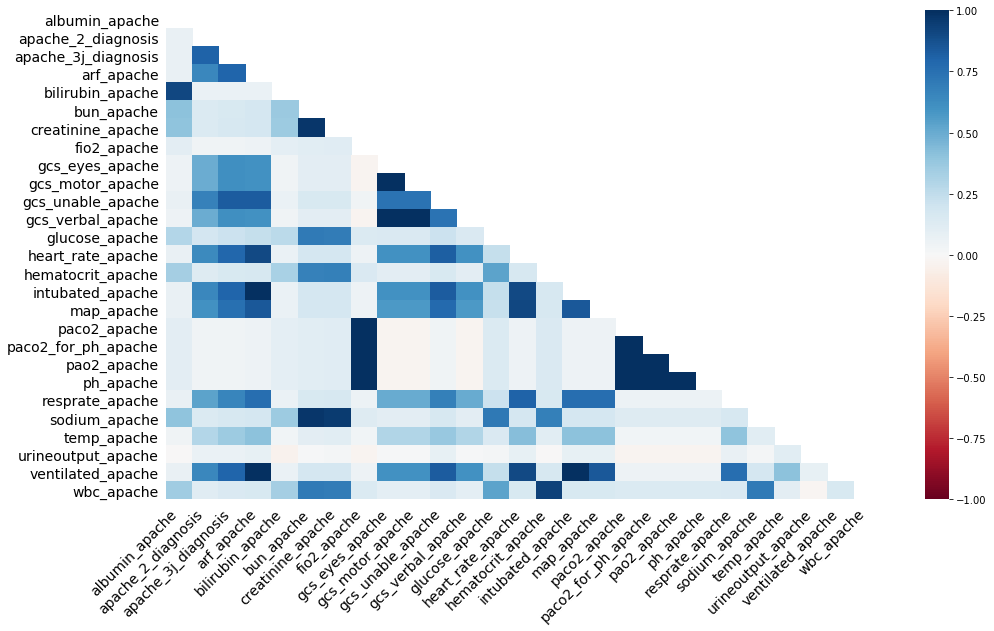

vitals


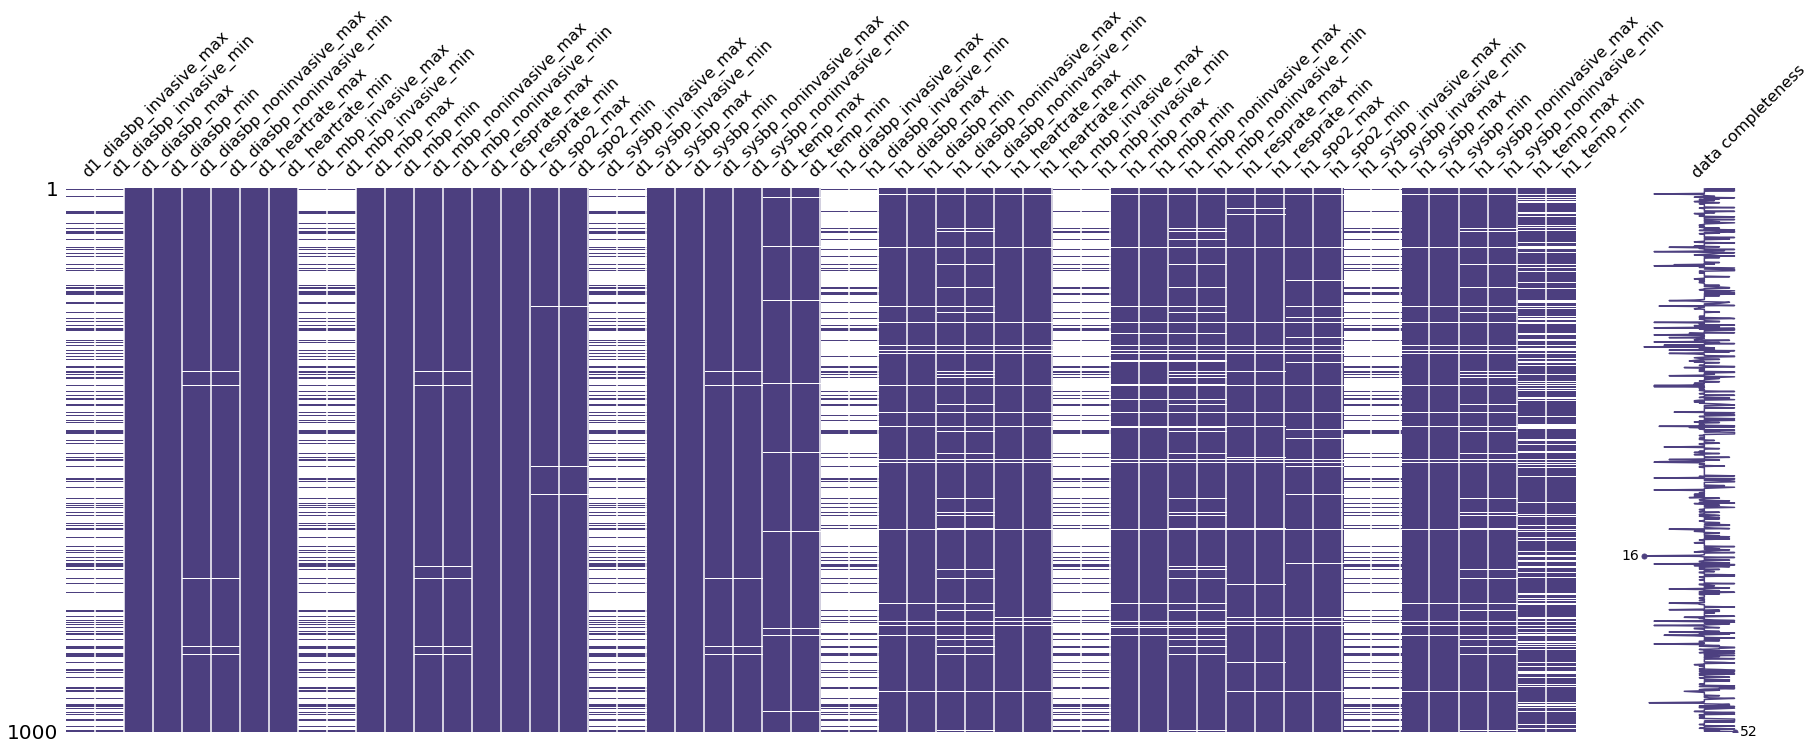

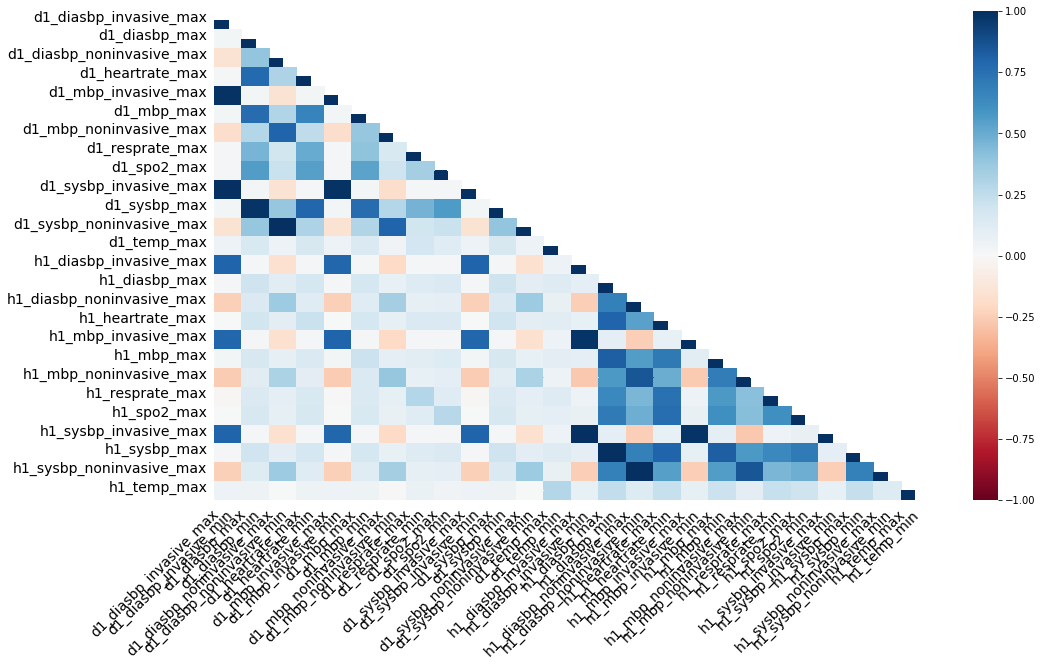

labs


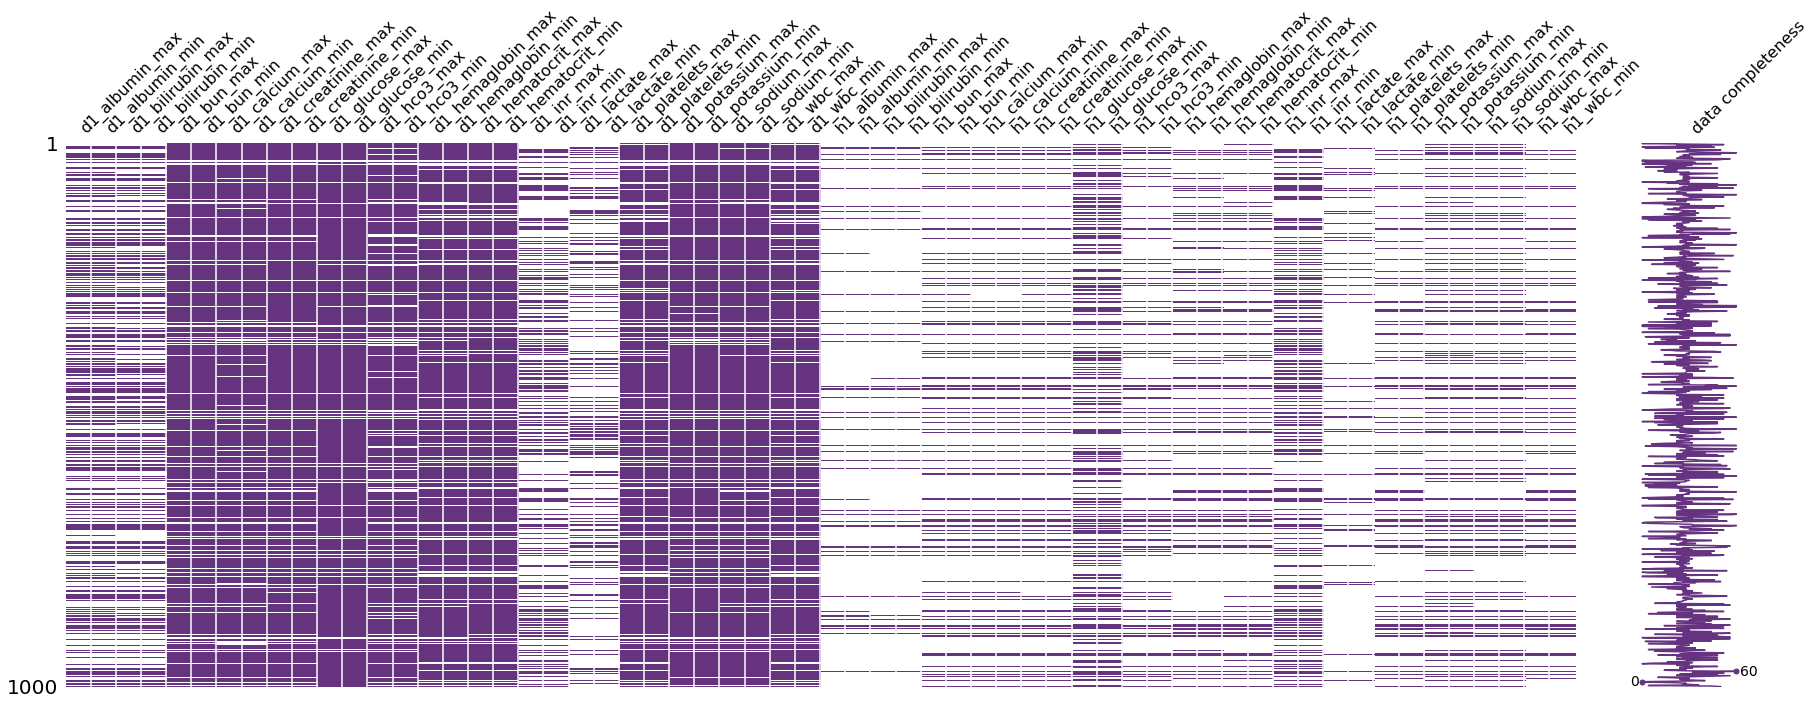

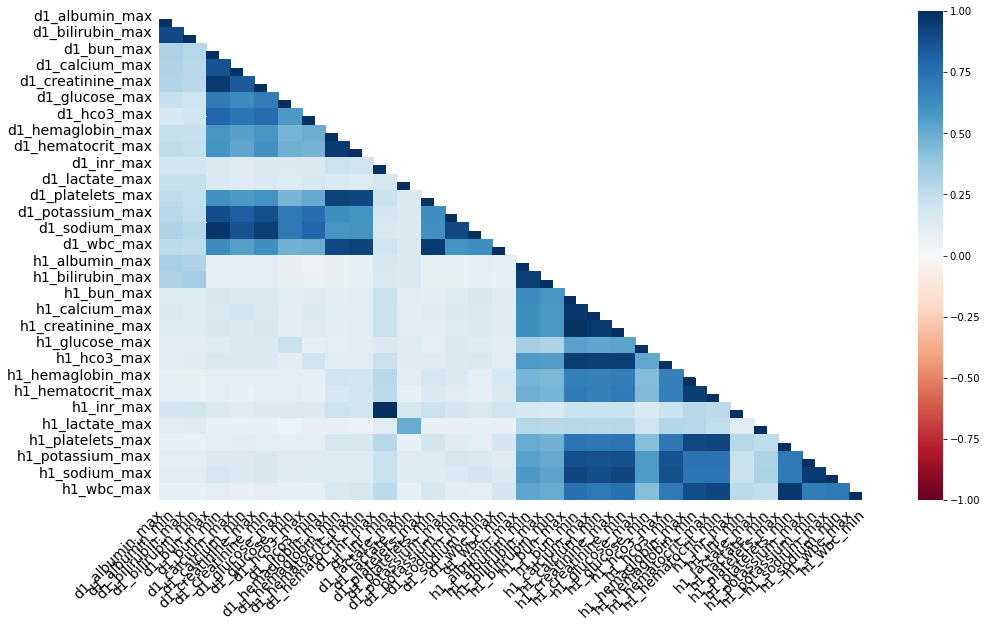

labs blood gas


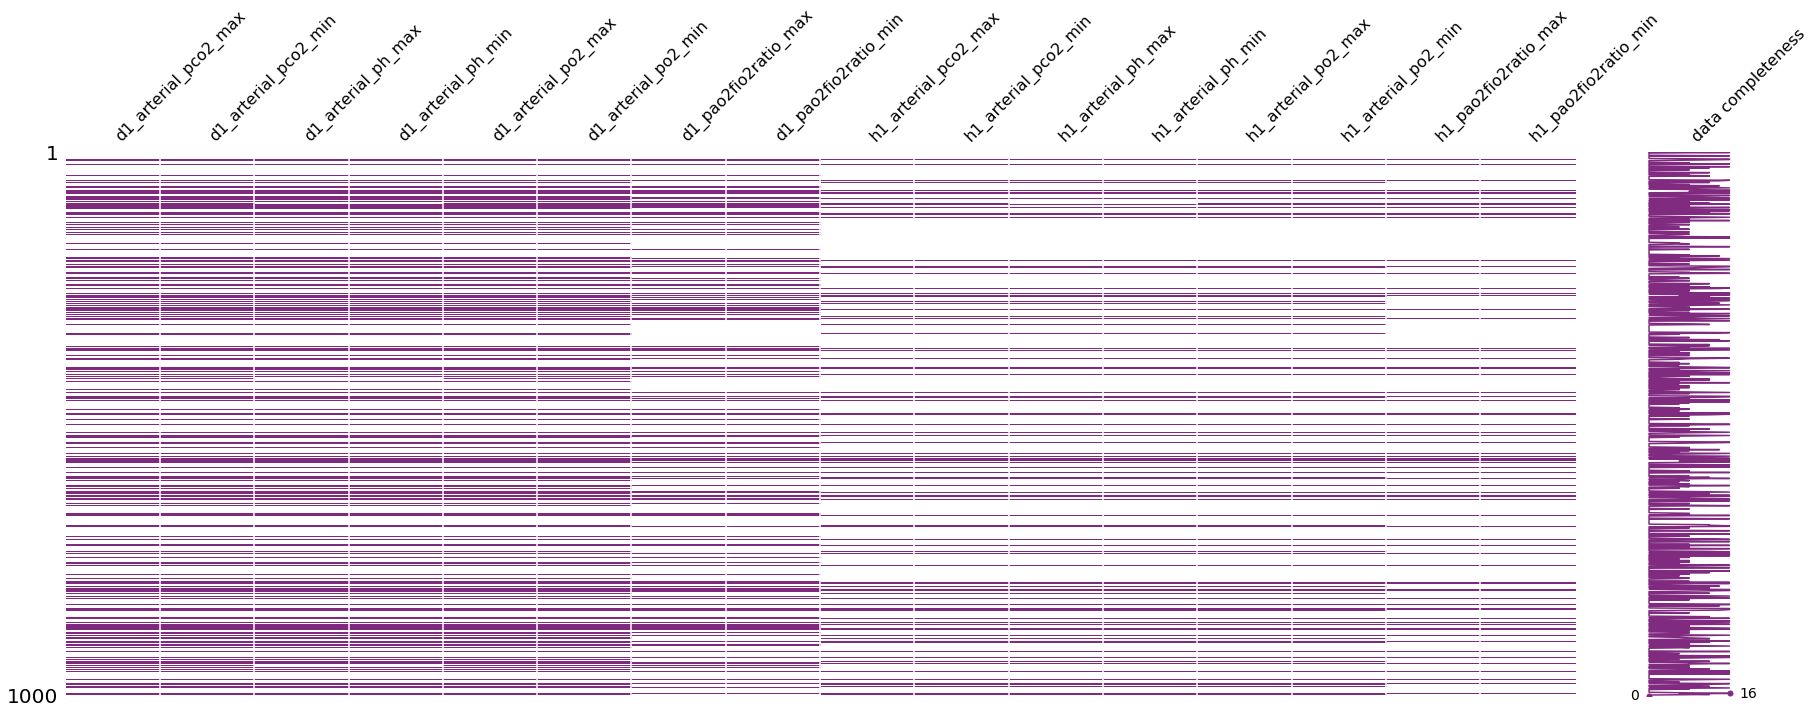

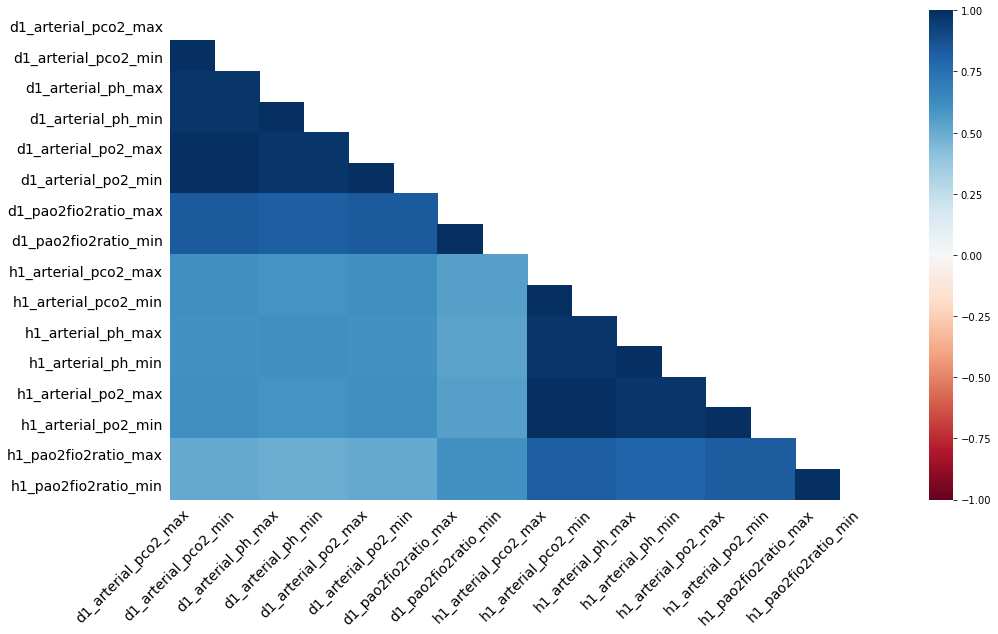

APACHE prediction


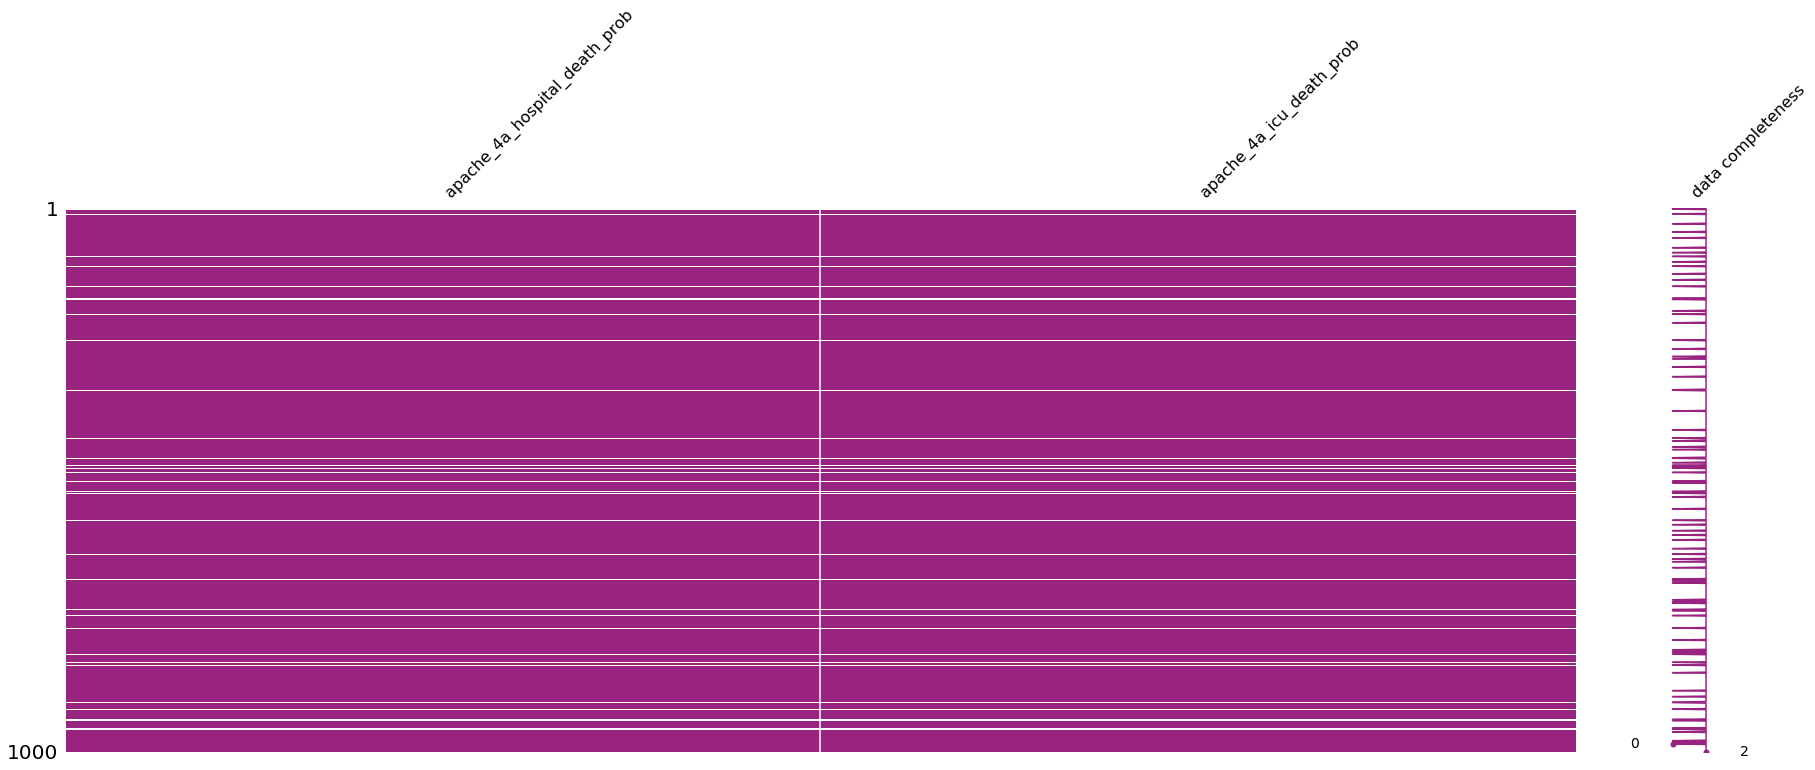

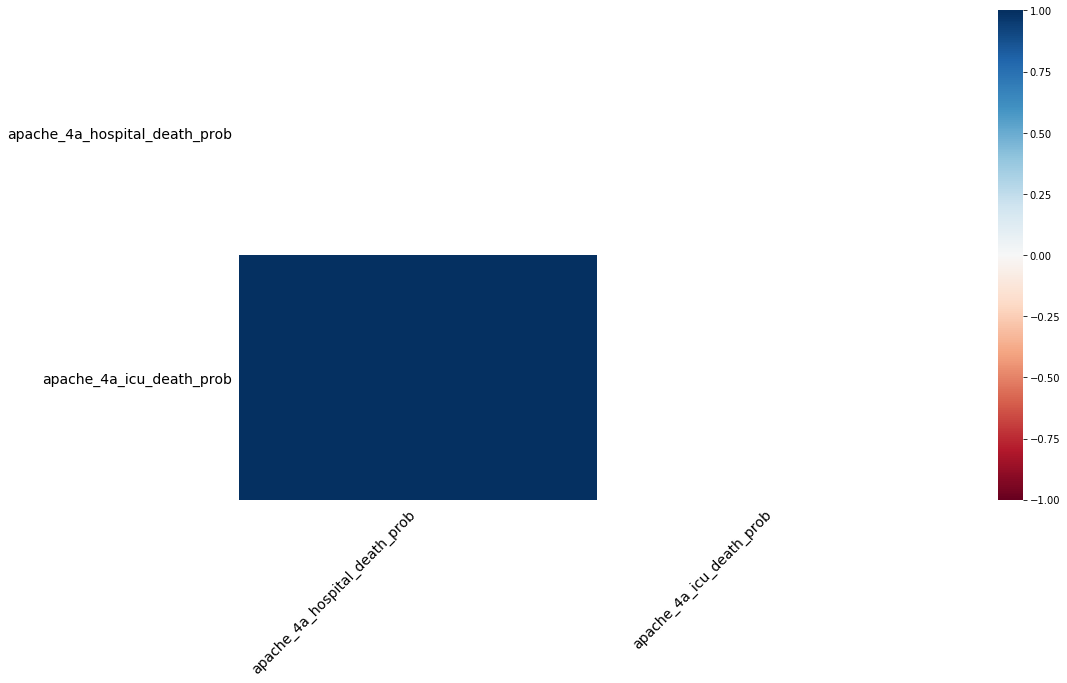

APACHE comorbidity


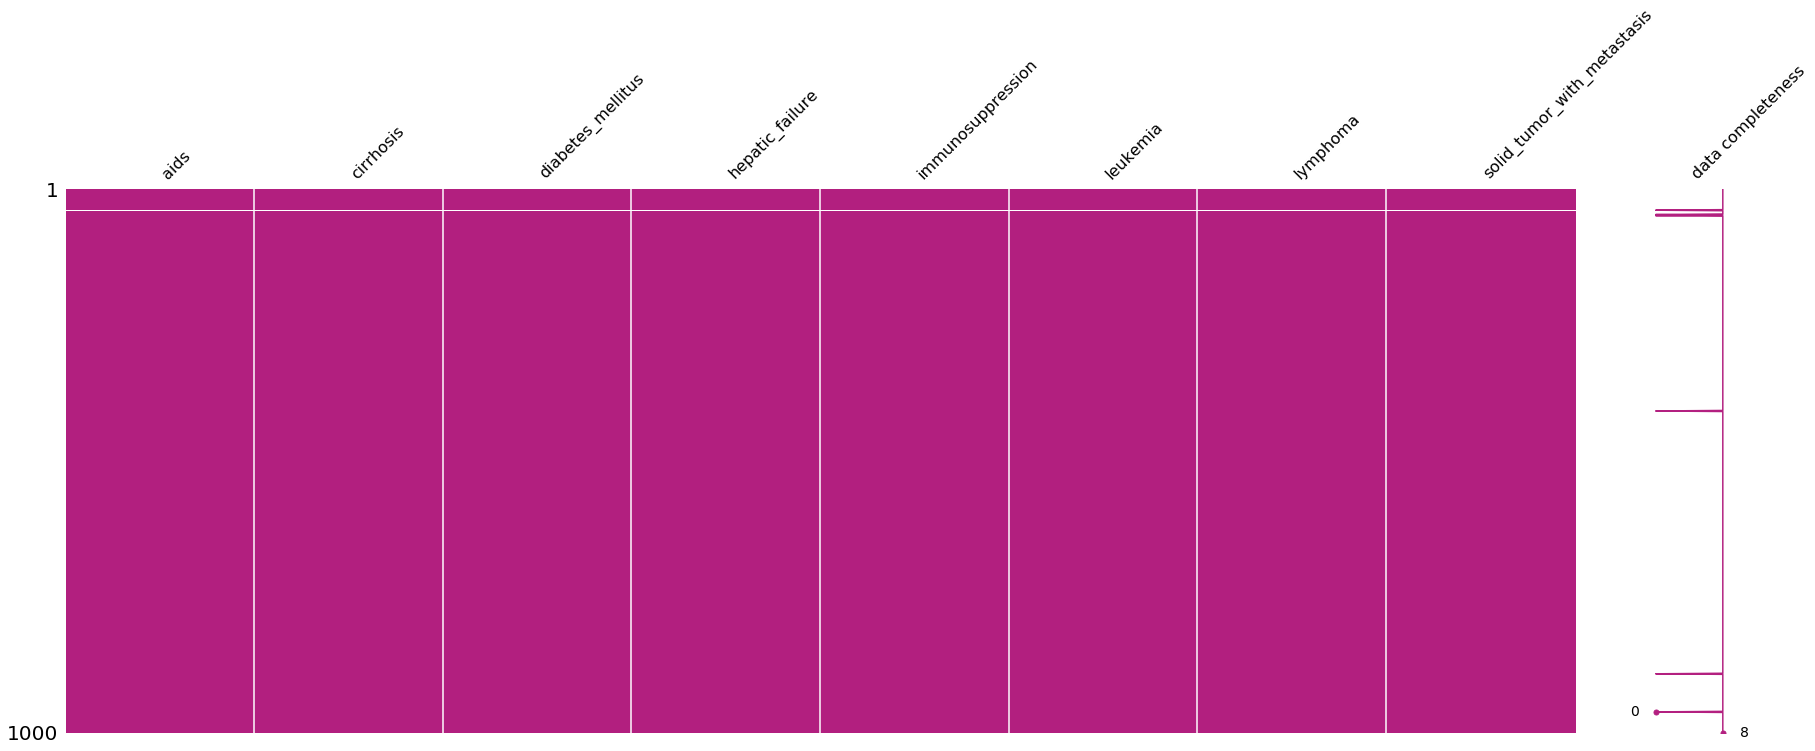

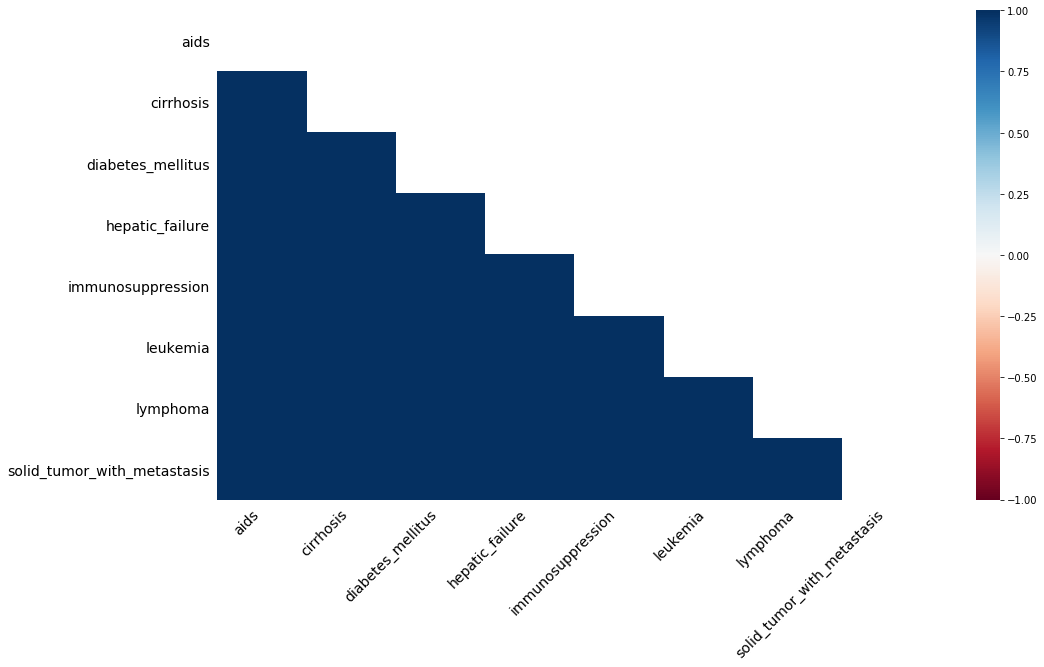

APACHE grouping


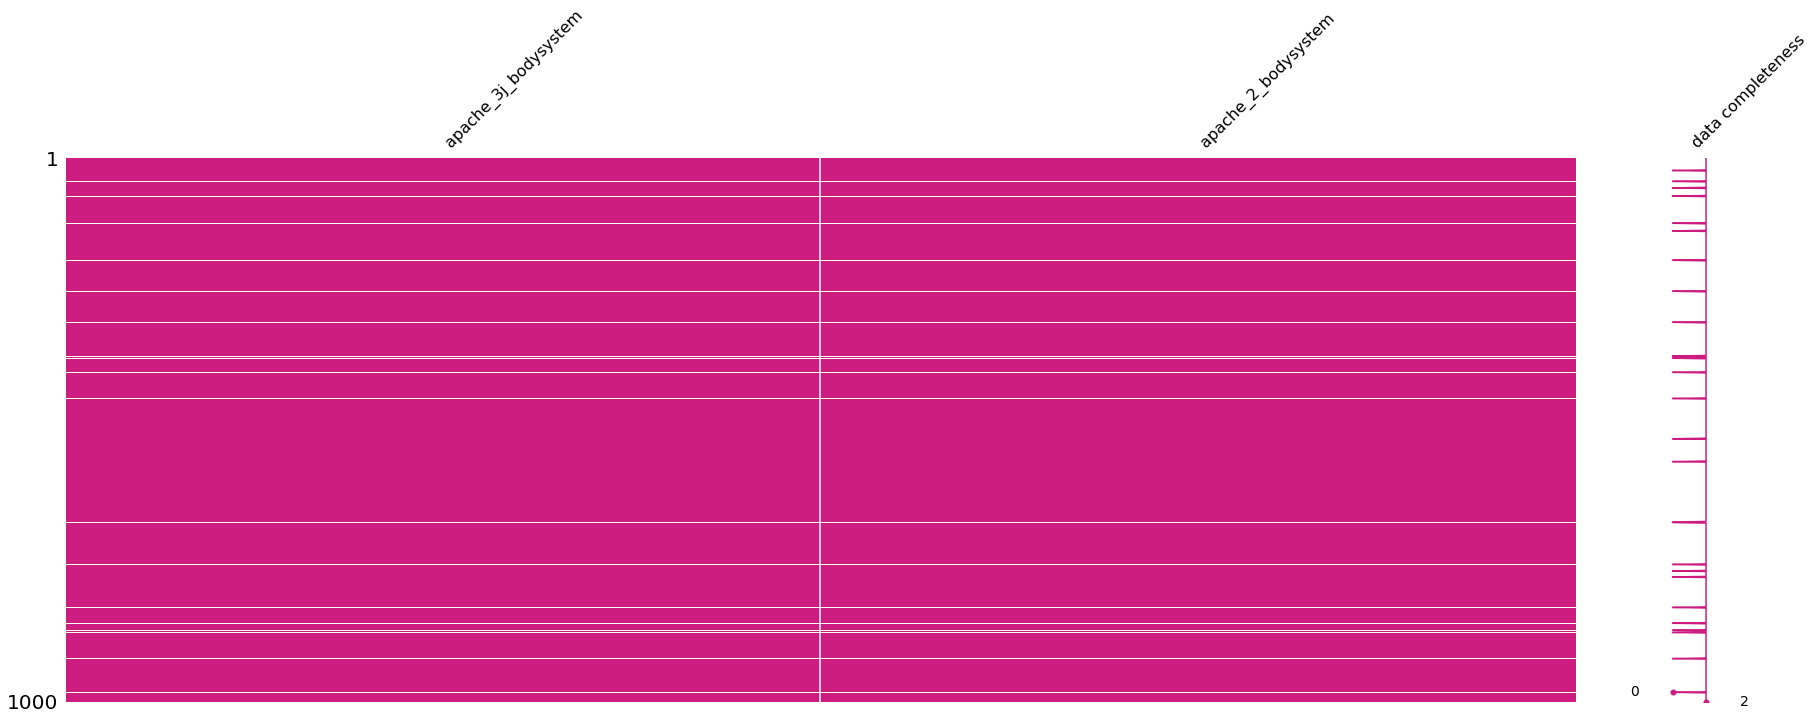

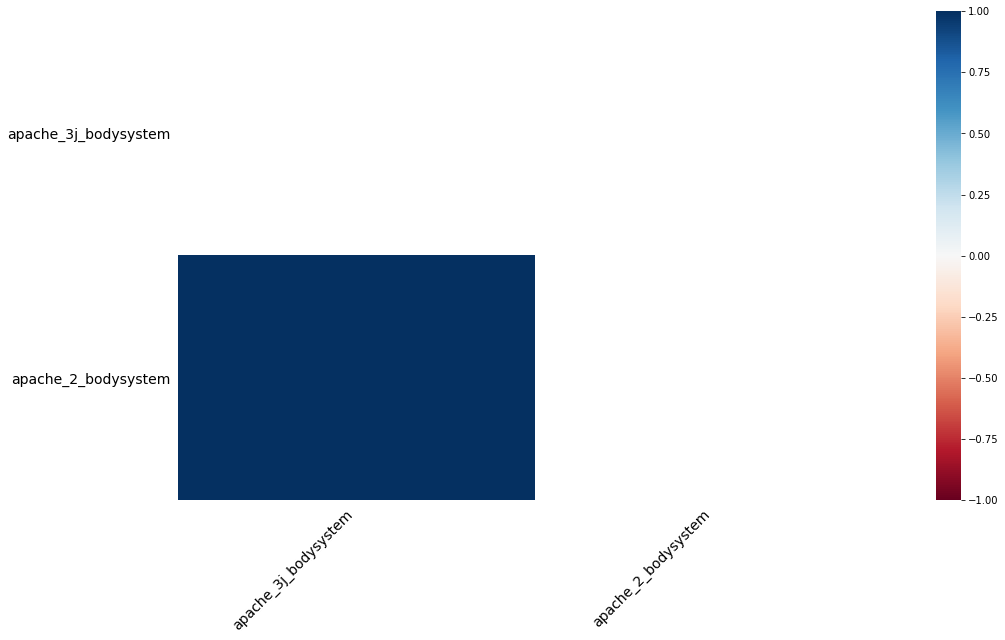

In [5]:
import missingno as msno
import matplotlib.pyplot as plt

for color, variable in enumerate(data_dict["Category"].unique()):
    if variable not in ["GOSSIS example prediction", "identifier"]:
        print(variable)
        column_list = data_dict[data_dict["Category"] == variable]["Variable Name"].values.tolist()
        column_list = [f for f in column_list if f in df.columns]
        if len(column_list) > 0:
            msno.matrix(
                df[column_list].sample(1000),
                figsize=(30, 10),
                labels=True,
                color=(color / 10, 1 / (color + 1), 0.5),
                fontsize=16,
            )
            msno.heatmap(
                df[column_list], figsize=(16, 9), labels=False, fontsize=14
            )
            plt.show()

# Preparation: Challenges Faced and How We Handled Them

## Null Values: A Different Beast in an Imbalanced Data Set
Since our target value (patient survivability) we're attempting to predict is imbalanced in our dataset, this affects our ability to handle nulls through blanket fixes. What we'll have to do is correlate the significance of the missing values against our target value to identify if the missing values are actually playing a role in patient survivability. 

> Below, we've run through each feature in our dataset to identify if the feature is dependent or independent of hospital_death. 

In [6]:
src.explore.significance_testing_of_nulls(df)

(encounter_id and hospital_death) are  independent of each other. (p = 0.4984475106646044)
(hospital_id and hospital_death) are  dependent of each other. (p = 3.971188907548724e-148)
(hospital_death and hospital_death) are  dependent of each other. (p = 0.0)
(age and hospital_death) are  dependent of each other. (p = 4.3986226670688454e-204)
(bmi and hospital_death) are  independent of each other. (p = 0.10323036630688469)
(elective_surgery and hospital_death) are  dependent of each other. (p = 1.8111023373323387e-176)
(ethnicity and hospital_death) are  dependent of each other. (p = 0.0031164745025517304)
(gender and hospital_death) are  dependent of each other. (p = 0.03441709366041668)
(height and hospital_death) are  dependent of each other. (p = 0.0021710052871524873)
(hospital_admit_source and hospital_death) are  dependent of each other. (p = 1.2519350471326363e-197)
(icu_admit_source and hospital_death) are  dependent of each other. (p = 3.7031521455538844e-243)
(icu_id and hos

(h1_temp_max and hospital_death) are  dependent of each other. (p = 0.0)
(h1_temp_min and hospital_death) are  dependent of each other. (p = 0.0)
(d1_albumin_max and hospital_death) are  dependent of each other. (p = 6.859150280616564e-281)
(d1_albumin_min and hospital_death) are  dependent of each other. (p = 0.0)
(d1_bilirubin_max and hospital_death) are  dependent of each other. (p = 6.817187257896686e-175)
(d1_bilirubin_min and hospital_death) are  dependent of each other. (p = 1.7869567361663835e-152)
(d1_bun_max and hospital_death) are  dependent of each other. (p = 0.0)
(d1_bun_min and hospital_death) are  dependent of each other. (p = 0.0)
(d1_calcium_max and hospital_death) are  dependent of each other. (p = 1.8212443271242305e-270)
(d1_calcium_min and hospital_death) are  dependent of each other. (p = 0.0)
(d1_creatinine_max and hospital_death) are  dependent of each other. (p = 0.0)
(d1_creatinine_min and hospital_death) are  dependent of each other. (p = 0.0)
(d1_glucose_ma

What do we get from this? This helped us identify the features which were independent of our target variable, and much more useful for our models than the other features. 

## Splitting the Data for Exploration

Now that we've taken a look at the data in broad strokes, it's time to split it so we're not spoiling our test data.

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
train, test = train_test_split(
    df, train_size=0.8, random_state=42, stratify=df.hospital_death
)

## Applying Wrangle to the Split Data

In [9]:
for df in [train, test]:
    df.pipe(src.wrangle.prepare_data)

In [10]:
# Making sure there's no missing data in the train or test
train.isna().sum().sum(), test.isna().sum().sum()

(0, 0)

In [11]:
# Looking at how the data was split
train.shape, test.shape

((73370, 185), (18343, 185))

# Exploration: Examining Which Factors are Affecting Patient Survival

## Average Hospital Death Probability by Gender

In [12]:
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots

In [13]:
female_age_death = (
    train[train["gender"] == "F"][["age", "hospital_death"]]
    .groupby("age")
    .mean()
    .reset_index()
)

In [14]:
male_age_death = (
    train[train["gender"] == "M"][["age", "hospital_death"]]
    .groupby("age")
    .mean()
    .reset_index()
)

In [15]:
fig = make_subplots()
fig.add_trace(
    go.Scatter(
        x=female_age_death["age"], y=female_age_death["hospital_death"], name="Female patients"
    )
)
fig.add_trace(
    go.Scatter(
        x=male_age_death["age"], y=male_age_death["hospital_death"], name="Male patients"
    )
)
fig.update_layout(title_text="<b>Average Hospital Death Probability By Gender<b>")
fig.update_xaxes(title_text="<b>Patient Age<b>")
fig.update_yaxes(title_text="<b>Average Hospital Death</b>", secondary_y=False)
fig.show()

# Uncomment this code to create the HTML file to embed chart
#pio.write_html(fig, file='index.html', auto_open=True)

## Does the Amount of Time in the ICU Affect Survival Rate?

In [16]:
ICU_type = train[["icu_type", "age", "hospital_death"]]

In [17]:
ICU_day = train[train["pre_icu_los_days"] >= 0][
    ["icu_type", "pre_icu_los_days", "hospital_death"]
]
ICU_day["icu_type"] = ICU_type["icu_type"].replace(
    {
        "MICU": "Medical ICU",
        "Neuro ICU": "Neurology ICU",
        "CCU-CTICU": "Cardiothoracic ICU",
        "CTICU": "Cardiothoracic ICU",
        "SICU": "Surgical ICU ",
        "CSICU": "Cardiac Surgery ICU",
        "Med-Surg ICU": "Medical Surgical ICU"
    }
)
ICU_day["pre_icu_los_days"] = ICU_day["pre_icu_los_days"].round(0)
ICU_df = ICU_day.groupby(["icu_type", "pre_icu_los_days"]).mean().reset_index()
ICU_df["count"] = (
    ICU_day.groupby(["icu_type", "pre_icu_los_days"])
    .sum()
    .reset_index()["hospital_death"]
)

fig = px.scatter(
    ICU_df,
    x="pre_icu_los_days",
    y="hospital_death",
    size="count",
    color="icu_type",
    hover_name="icu_type",
    log_x=True,
    size_max=200,
)

fig.update_layout(legend_title_text='ICU Type')
fig.update_layout(
    title_text="<b>Survival rate at different length of stay before ICU admission<b>"
)
fig.update_yaxes(title_text="<b>Average Hospital Death<b>")
fig.update_xaxes(
    title_text="<b>The length of stay of the patient between hospital admission and unit admission <b>"
)
fig.show()

# Uncomment this code to create the HTML file to embed chart
#pio.write_html(fig, file='index.html', auto_open=True)

## Does the Type of ICU affect Survival Chances?

In [18]:
ICU_type["icu_type"] = ICU_type["icu_type"].replace(
    {
        "Med-Surg ICU": "Medical Surgical ICU",
        "MICU": "Medical ICU",
        "Neuro ICU": "Neurology ICU",
        "CCU-CTICU": "Cardiothoracic ICU",
        "CTICU": "Cardiothoracic ICU",
        "SICU": "Surgical ICU ",
        "CSICU": "Cardiac Surgery ICU",
    }
)

In [19]:
ICU_df = ICU_type.groupby(["icu_type", "age"]).mean().reset_index()
ICU_df["count"] = (
    ICU_type.groupby(["icu_type", "age"]).count().reset_index()["hospital_death"]
)

In [20]:
fig = px.scatter(
    ICU_df,
    x="age",
    y="hospital_death",
    size="count",
    color="icu_type",
    hover_name="icu_type",
    log_x=False,
    size_max=40,
)

fig.update_layout(legend_title_text='ICU Type')
fig.update_layout(title_text="<b>Survival rate at different types of ICU<b>")
fig.update_yaxes(title_text="<b>Average Hospital Death<b>")
fig.update_xaxes(title_text="<b>Age<b>")
fig.show()

# Uncomment this code to create the HTML file to embed chart
#pio.write_html(fig, file='index.html', auto_open=True)

## How Much Does the Age of the Patient Affect Survival?

In [21]:
apache3=train[['age','apache_3j_bodysystem','hospital_death']]
apache3=apache3.groupby(['apache_3j_bodysystem','age']).agg(['size','mean']).reset_index()

apache3['size']=apache3['hospital_death']['size']
apache3['mean']=apache3['hospital_death']['mean']

apache3.drop('hospital_death',axis=1,inplace=True)

systems = apache3['apache_3j_bodysystem'].unique().tolist()
data = []
list_updatemenus = []
for n, s in enumerate(systems):
    visible = [False] * len(systems)
    visible[n] = True
    temp_dict = dict(label = str(s),
                 method = 'update',
                 args = [{'visible': visible},
                         {'title': '<b>'+s+'<b>'}])
    list_updatemenus.append(temp_dict)
    

for s in systems:
    mask = (apache3['apache_3j_bodysystem'].values == s) 
    trace = (dict(visible = False,     
        x = apache3.loc[mask, 'age'],
        y = apache3.loc[mask, 'mean'],
        mode = 'markers',
        marker = {'size':apache3.loc[mask, 'size']/apache3.loc[mask,'size'].sum()*1000,
                 'color':apache3.loc[mask, 'mean'],
                 'showscale': True})
                   )
    data.append(trace)

data[0]['visible'] = True

layout = dict(
    updatemenus=[dict(buttons=list_updatemenus)],
    xaxis=dict(
        title="<b>Age<b>",
        range=[min(apache3.loc[:, "age"]) - 10, max(apache3.loc[:, "age"]) + 10],
    ),
    yaxis=dict(
        title="<b>Average Hospital Death<b>",
        range=[min(apache3.loc[:, "mean"]) - 0.1, max(apache3.loc[:, "mean"]) + 0.1],
    ),
    title="<b>Survival Rate<b>",
)

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='update_dropdown')

# Uncomment this code to create the HTML file to embed chart
#pio.write_html(fig, file='index.html', auto_open=True)

In [104]:
train, test = train_test_split(
    df, train_size=0.8, random_state=42, stratify=df.hospital_death
)

(0, 16)

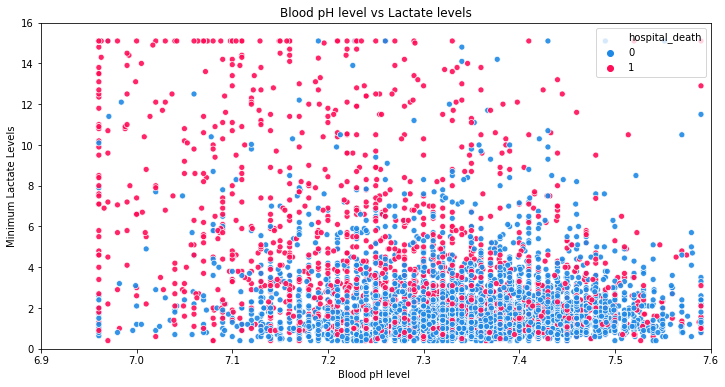

In [105]:
my_pal = {1: "#FF0D57", 0: "#1E88E5"}
plt.figure(figsize = (12,6))
sns.scatterplot(x = 'ph_apache', y = 'd1_lactate_min', data = train, hue = 'hospital_death', alpha = 0.9, palette= my_pal)
# plt.grid()
plt.legend(loc='upper right')
plt.ylabel('Minimum Lactate Levels')
plt.xlabel('Blood pH level ')
plt.title('Blood pH level vs Lactate levels')
plt.xlim (6.9,7.6)
plt.ylim(0, 16)

Text(0.5, 1.0, 'Blood pH level vs body temperature')

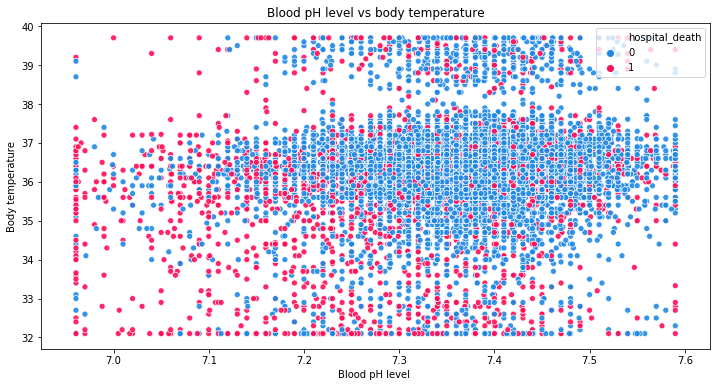

In [106]:
plt.figure(figsize = (12,6))
sns.scatterplot(x = 'ph_apache', y = 'temp_apache', data = train, hue = 'hospital_death', alpha = 0.9, palette= my_pal)
# plt.grid()
plt.legend(loc='upper right')
plt.ylabel('Body temperature')
plt.xlabel('Blood pH level ')
plt.title('Blood pH level vs body temperature')

Text(0.5, 1.0, 'Blood pH level vs body temperature')

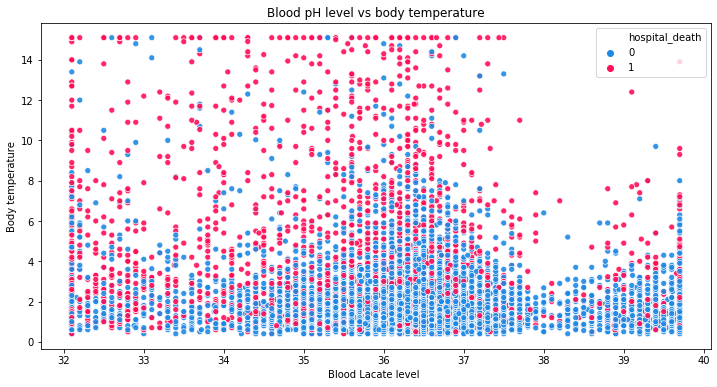

In [107]:
plt.figure(figsize = (12,6))
sns.scatterplot(y = 'd1_lactate_min', x = 'temp_apache', data = train, hue = 'hospital_death', alpha = 0.9, palette= my_pal)
plt.legend(loc='upper right')
plt.ylabel('Body temperature')
plt.xlabel('Blood Lacate level ')
plt.title('Blood pH level vs body temperature')

Text(0.5, 1.0, 'Blood pH vs body temperature')

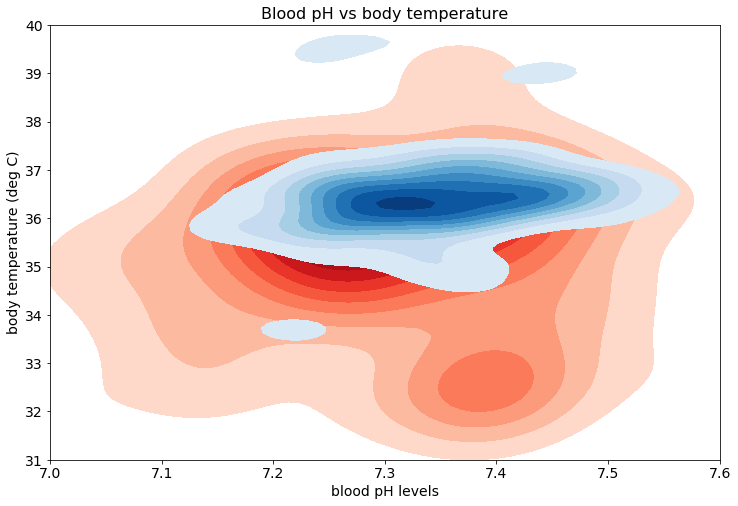

In [108]:
# Contour plot for blood pH level vs body temperature
plt.figure(figsize = (12,8))
plt.xlim(7.0,7.6)
plt.ylim(31,40)

died = train[train.hospital_death == 1].dropna()
survived = train[train.hospital_death == 0].dropna()
ax = sns.kdeplot(died.ph_apache, died.temp_apache,
                  cmap="Reds", shade=True, shade_lowest=False)
ax = sns.kdeplot(survived.ph_apache, survived.temp_apache,
                 cmap="Blues", shade=True, shade_lowest=False)
plt.xlabel('blood pH levels', fontsize = 14)
plt.ylabel('body temperature (deg C)', fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title('Blood pH vs body temperature',fontsize = 16)

Text(0.5, 1.0, 'Blood pH vs lactate level')

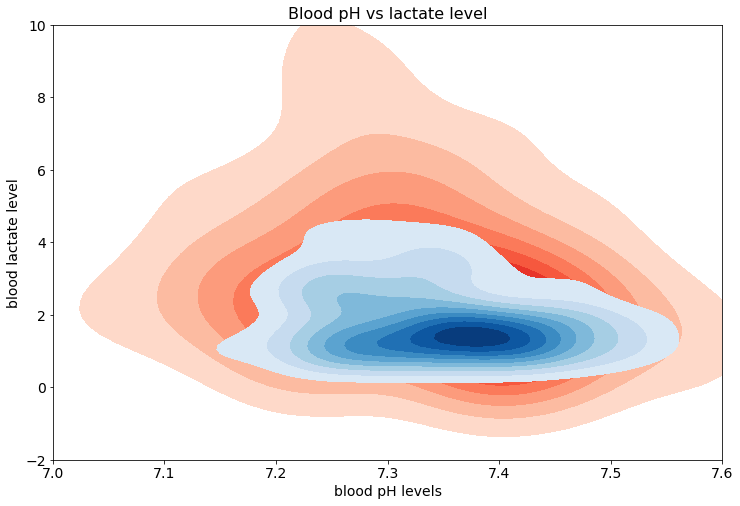

In [109]:
# Contour plot for blood pH level vs lactate level
plt.figure(figsize = (12,8))
plt.xlim(7.0,7.6)
plt.ylim(-2,10)

died = train[train.hospital_death == 1].dropna()
survived = train[train.hospital_death == 0].dropna()
ax = sns.kdeplot(died.ph_apache, died.d1_lactate_min,
                  cmap="Reds", shade=True, shade_lowest=False)
ax = sns.kdeplot(survived.ph_apache, survived.d1_lactate_min,
                 cmap="Blues", shade=True, shade_lowest=False)
plt.xlabel('blood pH levels',fontsize = 14)
plt.ylabel('blood lactate level', fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title('Blood pH vs lactate level', fontsize = 16)

In [27]:
# Make a list of diagnosis codes. The relationship between apache codes and the description can be found here:
# https://www.anzics.com.au/wp-content/uploads/2018/08/ANZICS-APD-Data-Dictionary.pdf

# Make a list of diagnoistis code in data
diagnosis_codes = df.apache_3j_diagnosis.value_counts().index.to_list()



In [28]:
# Make a dataframe with diagnosis code, # of pt survived, # of pt died and ratio of died vs survived

diag = pd.DataFrame( columns = ['diagnosis', 'died', 'survived','ratio', 'mortality_rate'])

for i in range(0, len(diagnosis_codes)):
    died = df[df.apache_3j_diagnosis== diagnosis_codes[i]][df.hospital_death ==1].shape[0]
    survived = df[df.apache_3j_diagnosis== diagnosis_codes[i]][df.hospital_death ==0].shape[0]
    if survived == 0:
        continue
    ratio = round(died/survived,2)
    mortality_rate = round(survived/(died+survived) * 100,2)
    diag = diag.append({'diagnosis': diagnosis_codes[i] , 'died': died, 'survived': survived, 'ratio': ratio, 'mortality_rate': mortality_rate}, ignore_index = True)

In [29]:
#check the new dataframe and sort values by 'died'
diag_sorted = diag.sort_values(by = [ 'died'], ascending = False).head(11).drop(diag.index[0])
diag_sorted

diagnosis   died  survived  ratio  mortality_rate
9      102.01  247.0     197.0   1.25           44.37
3      403.01   75.0     643.0   0.12           89.55
5      104.01   64.0     548.0   0.12           89.54
15     501.02   59.0     242.0   0.24           80.40
7      502.01   57.0     503.0   0.11           89.82
10     212.01   56.0     355.0   0.16           86.37
1      107.01   50.0     808.0   0.06           94.17
20     501.06   46.0     202.0   0.23           81.45
2      106.01   45.0     749.0   0.06           94.33
18     401.01   44.0     213.0   0.21           82.88

In [30]:
# we will look at top 9 diagnosis except for 'other' which is just aggreagation of low frquency diagnosis
# Replace diagnosis code with actual names
diag_sorted.iloc[0,0] = 'Cardiac arrest'
diag_sorted.iloc[1,0] = 'Pulmonary sepsis'
diag_sorted.iloc[2,0] = 'Stroke'
diag_sorted.iloc[3,0] = 'Heart failure'
diag_sorted.iloc[4,0] = 'GI sepsis'
diag_sorted.iloc[5,0] = 'Pneumonia'
diag_sorted.iloc[6,0] =  'UTI Sepsis'
diag_sorted.iloc[7,0] = 'Respiratory arrest'
diag_sorted.iloc[8,0] = 'Unknown Sepsis'
diag_sorted.iloc[9,0] = 'Brain Haemorrhage'

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text yticklabel objects>)

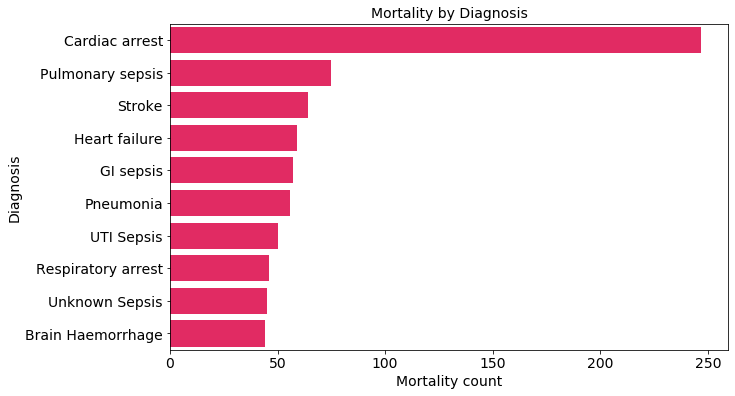

In [31]:
# Lets plot the top 10 
plt.figure(figsize=(10,6))
ax = sns.barplot(y = 'diagnosis', x = 'died', data = diag_sorted, color = '#FF0D57')
plt.xlabel('Mortality count', fontsize = 14)
plt.ylabel('Diagnosis', fontsize = 14)
plt.title('Mortality by Diagnosis', fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

# Feature Engineering

In [32]:
# Get raw data from again from csv file
df = pd.read_csv("data/training_v2.csv")

# Get data dictionary:
data_dict = pd.read_csv('data/WiDS Datathon 2020 Dictionary.csv')

In [33]:
# Get the list of categorical features

df_obj = data_dict[(data_dict['Data Type'] == 'string') | (data_dict['Data Type'] == 'binary')]
cat_features = list(df_obj['Variable Name'].values)
for c in cat_features:
    if c not in data_dict.columns or c == 'hospital_death':
        cat_features.remove(c)
cat_features.remove('bmi')
print(f'cat_features: {cat_features}')

cat_features: ['ethnicity', 'hospital_admit_source', 'icu_admit_type', 'icu_type', 'apache_2_diagnosis', 'apache_post_operative', 'gcs_unable_apache', 'ventilated_apache', 'cirrhosis', 'hepatic_failure', 'leukemia', 'solid_tumor_with_metastasis', 'apache_2_bodysystem']


In [34]:
# Some data cleaning and processing done, but no imputation
df = src.wrangle.prepare_data_features(df)

In [35]:
# Create new features
df['gcs'] = df.gcs_eyes_apache + df.gcs_motor_apache + df.gcs_verbal_apache
df['almost_dead'] = np.where(((df.temp_apache <= 38) & ((df.ph_apache < 7.1) | (df.ph_apache < 7.3 )) & (df.temp_apache<35) |((df.ph_apache < 7.1 )) & (df.map_apache < 50) | ((df.ph_apache < 7.2 )) & (df.gcs < 5) | (df.pre_icu_los_days > 40)) | ((df.d1_lactate_max > 8) | (df.d1_lactate_min > 10)),True,False)
df['arterial_bp'] = np.where((df.d1_mbp_invasive_max.notnull()), True, False)
df['ventilated_apache'] = np.where(((df['ventilated_apache'].isnull()) & (df.h1_arterial_po2_min.notnull())), 1.0, df['ventilated_apache'])
df['ventilated_apache'] = np.where((df['ventilated_apache'].isnull()), 0.0, df['ventilated_apache'])
df['bool_'+ 'h1_lactate_max'] = np.where(pd.notnull(df['h1_lactate_max']), True, False)

In [36]:
#consolidate some categories for icu_type and 'hospital_admit_source'

df['icu_type']=df['icu_type'].replace({'CTICU':'CCU-CTICU',
                                              'Cardiac ICU':'CCT-CTICU',
                                              'CTICU':'CCT-CTICU',
                                              'CSICU':'SICU'})

df['hospital_admit_source']= df['hospital_admit_source'].replace({
                                        'Other ICU':"ICU",'ICU to SDU':"SDU",
                                       'Step-Down Unit (SDU)':"SDU",
                                      'Acute Care/Floor':"Floor",
                                      'Other Hospital':"Other"})

In [37]:
# list of variables missing more than 80% values
# list of variables missing more than 80% values
missing = []
for col in df.columns:
    if df[col].isnull().mean() > 0.8:
        missing.append(col)
missing

['h1_diasbp_invasive_max',
 'h1_diasbp_invasive_min',
 'h1_mbp_invasive_max',
 'h1_mbp_invasive_min',
 'h1_sysbp_invasive_max',
 'h1_sysbp_invasive_min',
 'h1_albumin_max',
 'h1_albumin_min',
 'h1_bilirubin_max',
 'h1_bilirubin_min',
 'h1_bun_max',
 'h1_bun_min',
 'h1_calcium_max',
 'h1_calcium_min',
 'h1_creatinine_max',
 'h1_creatinine_min',
 'h1_hco3_max',
 'h1_hco3_min',
 'h1_hematocrit_max',
 'h1_hematocrit_min',
 'h1_lactate_max',
 'h1_lactate_min',
 'h1_platelets_max',
 'h1_platelets_min',
 'h1_wbc_max',
 'h1_wbc_min',
 'h1_arterial_pco2_max',
 'h1_arterial_pco2_min',
 'h1_arterial_ph_max',
 'h1_arterial_ph_min',
 'h1_arterial_po2_max',
 'h1_arterial_po2_min',
 'h1_pao2fio2ratio_max',
 'h1_pao2fio2ratio_min']

In [38]:
# other columns to remove
to_remove=['icu_id','patient_id','encounter_id','apache_4a_hospital_death_prob','apache_4a_icu_death_prob','readmission_status', 'apache_2_bodysystem', 'hospital_id' ]

In [39]:
#list of variables identified, values of which will be identified against the mean for patients with same diagnosis
apache = [ 'age', 'bmi', 'height','weight', 'albumin_apache','arf_apache','bilirubin_apache','bun_apache',
          'creatinine_apache','fio2_apache','glucose_apache', 'heart_rate_apache','hematocrit_apache',
         'intubated_apache', 'map_apache','paco2_apache','pao2_apache','ph_apache','resprate_apache',
          'sodium_apache','temp_apache','urineoutput_apache','ventilated_apache', 'wbc_apache']

In [40]:
# get list of diagnosis in data
diagnosis = df.apache_2_diagnosis.value_counts().index
diagnosis = diagnosis.astype(str)

In [41]:
# create a empty dataframe (with NaNs) with index as apache variables and columns as diagnosis
df_means = pd.DataFrame(index=apache, columns= diagnosis)
df_means.head(2)

113.0 301.0 302.0 112.0 308.0 117.0 124.0 122.0 303.0 110.0 304.0 203.0  \
age   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
bmi   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

    202.0 106.0 305.0 114.0 121.0 123.0 102.0 307.0 119.0 120.0 118.0 108.0  \
age   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
bmi   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

    214.0 109.0 105.0 213.0 207.0 306.0 218.0 217.0 209.0 219.0 101.0 104.0  \
age   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
bmi   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

    103.0 115.0 116.0 107.0 215.0 208.0 212.0 216.0  
age   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
bmi   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN

In [42]:
# Fill the empty dataframe created above with mean values of for patients with same diagnosis:
for d in diagnosis:
    for a in apache:
        df_means[d][a] = df[df.apache_2_diagnosis == float(d)][a].mean()

df_means.head(2)

113.0    301.0    302.0    112.0    308.0    117.0    124.0    122.0  \
age  64.6395  63.3042  63.2816   63.748  63.7793  69.7777  66.4985  41.9204   
bmi  29.1053  28.9512  29.7945  29.4347  30.5397  29.4761  28.0408   27.844   

       303.0    110.0    304.0    203.0    202.0    106.0    305.0    114.0  \
age  62.2462  68.8166   61.621  69.3032  68.8343   65.558  58.7136  62.5583   
bmi   29.068  31.4086  29.5544  29.1144   28.468  28.8172  31.3788  29.9581   

       121.0    123.0    102.0    307.0    119.0    120.0    118.0    108.0  \
age  66.0796  43.7127  66.9973  60.3408  57.4853  52.1251  53.2238  63.3758   
bmi  27.4484  27.2402  30.0142   28.502  26.4958  27.7413  27.9283  30.1016   

       214.0    109.0    105.0    213.0    207.0    306.0    218.0    217.0  \
age  68.1451  56.4745  61.6461  66.2956  54.7947  61.2651   57.434  59.9051   
bmi  28.0588  30.8019  32.7656  28.4348  27.7849  28.3742  30.0609   28.414   

       209.0    219.0   101.0    104.0    103.0    115.0    116.0    107.0  \
age    64.62  61.2571  44.573  67.8795  59.6049  66.5285  65.6256  63.9492   
bmi  28.2362  30.5285  31.506  26.8084   31.486  29.1809  28.2941  25.8731   

       215.0    208.0    212.0    216.0  
age  68.6497  49.6942  60.7653  53.3462  
bmi  29.5407  27.0977  29.0655  27.1413

In [43]:
# create new columns named diff_col_name which is difference between apache variables and
# corresponding mean values for patients with same diagnosis:
for a in apache:
    for d in diagnosis:
        df['diff_'+ a] = np.where(df[a].notnull(), df_means[d][a]-df[a], 0)

In [44]:
# drop columns which are missing more than 80% values
df.drop(columns = missing,axis=1,inplace=True)

In [45]:
# Drop columns with 'invasive in their names since they are redundant'
inv_cols=[s for s in df.columns.tolist() if "invasive" in s]
df.drop(inv_cols,axis=1,inplace=True)

In [46]:
# all features/columns in df
features = [col for col in df.columns]

In [47]:
# Function which takes all numerical columns and returns columns with correlation higher than 0.99
def drop_correlated_features(df):
    num_feature = [col for col in features if col not in cat_features and df[col].dtype != 'object']
    drop_columns=[]
    corr = df[num_feature].corr()

    columns = np.full((corr.shape[0],), True, dtype=bool)

    for i in range(corr.shape[0]):
        for j in range(i+1, corr.shape[0]):
            if corr.iloc[i,j] >=0.99 :
                if columns[j] == True:
                    columns[j] = False
                    print('col1: {} col2: {} - Correlation: {}'.format(df[num_feature].columns[i] , df[num_feature].columns[j], corr.iloc[i,j]))
            elif corr.iloc[i,j] <= -0.99:
                if columns[j] == True:
                    columns[j] = False

    drop_columns = df[num_feature].columns[columns == False].values
    return drop_columns

In [48]:
#list of correlated columns returned from function above
drop_columns = drop_correlated_features(df)

col1: bilirubin_apache col2: d1_bilirubin_max - Correlation: 0.9965677029378415
col1: bun_apache col2: d1_bun_max - Correlation: 0.9911211474368951
col1: creatinine_apache col2: d1_creatinine_max - Correlation: 0.9941463711670832
col1: paco2_apache col2: paco2_for_ph_apache - Correlation: 1.0
col1: d1_inr_max col2: h1_inr_max - Correlation: 1.0
col1: d1_inr_min col2: h1_inr_min - Correlation: 1.0


In [49]:
#list of highly correlated variables
drop_columns

array(['paco2_for_ph_apache', 'd1_bilirubin_max', 'd1_bun_max',
       'd1_creatinine_max', 'h1_inr_max', 'h1_inr_min', 'diff_age',
       'diff_bmi', 'diff_height', 'diff_weight', 'diff_albumin_apache',
       'diff_arf_apache', 'diff_bilirubin_apache', 'diff_bun_apache',
       'diff_creatinine_apache', 'diff_fio2_apache',
       'diff_glucose_apache', 'diff_heart_rate_apache',
       'diff_hematocrit_apache', 'diff_intubated_apache',
       'diff_map_apache', 'diff_paco2_apache', 'diff_pao2_apache',
       'diff_ph_apache', 'diff_resprate_apache', 'diff_sodium_apache',
       'diff_temp_apache', 'diff_urineoutput_apache', 'diff_wbc_apache'],
      dtype=object)

In [50]:
#drop columns identified above
features = [col for col in features if col not in drop_columns]
df = df[features]
df = df.drop(columns = to_remove)

In [51]:
# identify binary and categorical features
binary=[col for col in df.columns if df[col].nunique() == 2 and df[col].dtypes !='object']
categorical = [col for col in df.columns if df[col].dtypes == 'object']

# assign features to correct types
categorical.append('apache_2_diagnosis')
binary.remove('hospital_death')

In [52]:
#list of binary features
binary

['elective_surgery',
 'apache_post_operative',
 'arf_apache',
 'gcs_unable_apache',
 'intubated_apache',
 'ventilated_apache',
 'aids',
 'cirrhosis',
 'diabetes_mellitus',
 'hepatic_failure',
 'immunosuppression',
 'leukemia',
 'lymphoma',
 'solid_tumor_with_metastasis',
 'almost_dead',
 'arterial_bp',
 'bool_h1_lactate_max',
 'diff_ventilated_apache']

In [53]:
#list of categorical features
categorical

['ethnicity',
 'gender',
 'hospital_admit_source',
 'icu_admit_source',
 'icu_stay_type',
 'icu_type',
 'apache_3j_diagnosis',
 'apache_3j_bodysystem',
 'apache_2_diagnosis']

In [54]:
# for binary columns specify 0 as missing, 1 as 'no' and 2 as 'yes'
for col in binary:
    df[col]= df[col]+1
    df[col].fillna(0,inplace=True)
#     df[col]= df[col].astype(str)
    df[col]= df[col].astype(np.int64).astype('category')

In [55]:
# convert binary columns to int type
df['gcs_unable_apache'] = df['gcs_unable_apache'].astype('Int64')
for b in binary:
    df[b] = df[b].astype('Int64')

In [56]:
#identify numeric columns
numeric_col =[col for col in df.columns if  df[col].dtypes !='object' and col not in binary and col not in categorical]

# Modeling 

In [57]:
#create test train split
train, test = train_test_split(df, train_size = .80, random_state = 42, stratify = df.hospital_death)

In [58]:
#make DF for numerical columns only so that we can do scaling
numeric_train = train[numeric_col]
numeric_test = test[numeric_col]
numeric_train.head(2)

hospital_death   age        bmi  height  pre_icu_los_days  weight  \
59226               1  72.0  32.041330   154.9          0.061111   76.88   
81334               0  58.0  34.334291   190.5          0.032639  124.60   

       albumin_apache  bilirubin_apache  bun_apache  creatinine_apache  \
59226             2.0               2.4        26.0               1.64   
81334             2.5               1.2        70.0               2.85   

       fio2_apache  gcs_eyes_apache  gcs_motor_apache  gcs_verbal_apache  \
59226          NaN              4.0               6.0                4.0   
81334          NaN              1.0               1.0                1.0   

       glucose_apache  heart_rate_apache  hematocrit_apache  map_apache  \
59226           107.0               99.0               27.9        45.0   
81334           319.0              138.0               37.4        47.0   

       paco2_apache  pao2_apache  ph_apache  resprate_apache  sodium_apache  \
59226           NaN          NaN        NaN             13.0          135.0   
81334           NaN          NaN        NaN             53.0          117.0   

       temp_apache  urineoutput_apache  wbc_apache  d1_diasbp_max  \
59226         36.6                 NaN       22.81           95.0   
81334         36.2                 NaN       16.20          137.0   

       d1_diasbp_min  d1_heartrate_max  d1_heartrate_min  d1_mbp_max  \
59226           13.0             150.0              77.0       101.0   
81334           14.0             138.0              83.0       144.0   

       d1_mbp_min  d1_resprate_max  d1_resprate_min  d1_spo2_max  d1_spo2_min  \
59226        22.0             40.0             12.0        100.0         38.0   
81334        42.0             53.0             17.0         99.0         81.0   

       d1_sysbp_max  d1_sysbp_min  d1_temp_max  d1_temp_min  h1_diasbp_max  \
59226         161.0          48.0         36.7         35.8           51.0   
81334         161.0          77.0         37.8         36.2           64.0   

       h1_diasbp_min  h1_heartrate_max  h1_heartrate_min  h1_mbp_max  \
59226           39.0              94.0              92.0        59.0   
81334           22.0             128.0             116.0        86.0   

       h1_mbp_min  h1_resprate_max  h1_resprate_min  h1_spo2_max  h1_spo2_min  \
59226        47.0             19.0             16.0         98.0         96.0   
81334        42.0             53.0             30.0         98.0         96.0   

       h1_sysbp_max  h1_sysbp_min  h1_temp_max  h1_temp_min  d1_albumin_max  \
59226          85.0          72.0          NaN          NaN             2.0   
81334         121.0          96.0         37.8         37.4             2.6   

       d1_albumin_min  d1_bilirubin_min  d1_bun_min  d1_calcium_max  \
59226             2.0               2.4        26.0             7.1   
81334             2.5               1.0        63.0             8.5   

       d1_calcium_min  d1_creatinine_min  d1_glucose_max  d1_glucose_min  \
59226             7.1               1.64           132.0           107.0   
81334             8.1               2.44           319.0           212.0   

       d1_hco3_max  d1_hco3_min  d1_hemaglobin_max  d1_hemaglobin_min  \
59226         20.0         20.0               13.7                8.8   
81334         36.0         32.0               11.9               11.9   

       d1_hematocrit_max  d1_hematocrit_min  d1_inr_max  d1_inr_min  \
59226               43.6               27.9         1.8         1.8   
81334               37.4               37.4         1.4         1.4   

       d1_lactate_max  d1_lactate_min  d1_platelets_max  d1_platelets_min  \
59226             2.6             2.6              81.0              81.0   
81334             2.7             1.9             358.0             358.0   

       d1_potassium_max  d1_potassium_min  d1_sodium_max  d1_sodium_min  \
59226               4.1               4.1          135.0          135.0   


In [59]:
# dataframe for binary columns which allows us to do onehotencoding
binary_train = train[binary]
binary_test = test[binary]

# dataframe for categorical columns which allows us to do onehotencoding
categorical_train = train[categorical]
categorical_test = test[categorical]

In [60]:
# Fill categorical missing data with most frequent values 'mode'
for col in categorical_train:
    categorical_train[col].fillna(categorical_train[col].mode()[0],inplace=True)
    
for col in categorical_test:
    categorical_test[col].fillna(categorical_test[col].mode()[0],inplace=True)

In [61]:
# Scale numerical columns in both train and test

scaler = MinMaxScaler(copy=True, feature_range=(0,1)).fit(numeric_train)
numeric_train_scaled = pd.DataFrame(scaler.transform(numeric_train), columns=numeric_train.columns.values).set_index([numeric_train.index.values])

scaler1 = MinMaxScaler(copy=True, feature_range=(0,1)).fit(numeric_test)
numeric_test_scaled = pd.DataFrame(scaler1.transform(numeric_test), columns=numeric_test.columns.values).set_index([numeric_test.index.values])

## Encoding the Data

In [62]:
#create a list of columns which need to be onehotencoded
encode_columns = (list(binary_train.columns) + list(categorical_train.columns))

In [63]:
# concat the categorical and binary DF
train_concat = pd.concat([categorical_train, binary_train], axis =1)
test_concat = pd.concat([categorical_test, binary_test], axis =1)

In [64]:
# convert apache_3j_diagnosis as str type before hot encoding for train and test
train_concat.apache_3j_diagnosis = train_concat.apache_3j_diagnosis.astype(str)
test_concat.apache_3j_diagnosis = test_concat.apache_3j_diagnosis.astype(str)

In [65]:
#hot encode train and test non-numerical features for train and test
train_encoded = src.preprocessing.encode(train_concat, encode_columns)
test_encoded = src.preprocessing.encode(test_concat, encode_columns)

In [66]:
# concat numeric scaled and onehot encoded features for train and test
train = pd.concat([numeric_train_scaled ,train_encoded], axis =1)
test = pd.concat([numeric_test_scaled ,test_encoded], axis =1)

# train = pd.concat([numeric_train ,train_encoded], axis =1)
# test = pd.concat([numeric_test ,test_encoded], axis =1)

In [67]:
# Create X (predictors) and y (target)
y = train[['hospital_death']]
X = train.drop(columns = ['hospital_death'])

y_test = test[['hospital_death']]
X_test = test.drop(columns = ['hospital_death'])

### Logistic Regression

#### Logistic regression cannot handle NaNs, so we need to impute NaNs before modeling:-

In [68]:
#Imputation for numerical columns in train 
imp = IterativeImputer(max_iter=3, verbose=1)
imp.fit(numeric_train)
imputed_train = imp.transform(numeric_train)
imputed_train = pd.DataFrame(imputed_train, columns=numeric_train.columns, index = numeric_train.index)

[IterativeImputer] Completing matrix with shape (73370, 98)
[IterativeImputer] Change: 3148.6805895674647, scaled tolerance: 8.716669631999999 
[IterativeImputer] Change: 4787.515519169886, scaled tolerance: 8.716669631999999 
[IterativeImputer] Change: 19365.27528220752, scaled tolerance: 8.716669631999999 
[IterativeImputer] Completing matrix with shape (73370, 98)


In [69]:
#Imputation for numerical columns in test
impt = IterativeImputer(max_iter=3, verbose=1)
impt.fit(numeric_test)
imputed_test = impt.transform(numeric_test)
imputed_test = pd.DataFrame(imputed_test, columns=numeric_test.columns, index = numeric_test.index)

[IterativeImputer] Completing matrix with shape (18343, 98)
[IterativeImputer] Change: 2579.3901797861895, scaled tolerance: 8.716669631999999 
[IterativeImputer] Change: 8351.00573728371, scaled tolerance: 8.716669631999999 
[IterativeImputer] Change: 9003.449344791725, scaled tolerance: 8.716669631999999 
[IterativeImputer] Completing matrix with shape (18343, 98)


In [70]:
#scale the imputed numeric test and train columns
scaler3 = MinMaxScaler(copy=True, feature_range=(0,1)).fit(numeric_train)
numeric_train_scaled = pd.DataFrame(scaler3.transform(imputed_train), columns=imputed_train.columns.values).set_index([imputed_train.index.values])

scaler4 = MinMaxScaler(copy=True, feature_range=(0,1)).fit(numeric_test)
numeric_test_scaled = pd.DataFrame(scaler4.transform(imputed_test), columns=imputed_test.columns.values).set_index([imputed_test.index.values])

In [71]:
# combine scaled numeric columns with onehot encoded columns for both train and test
imputed_train = pd.concat([numeric_train_scaled ,train_encoded], axis =1)
Imputed_test = pd.concat([numeric_test_scaled ,test_encoded], axis =1)

In [72]:
# make train and test predictor and target dataframes
y = imputed_train[['hospital_death']]
X = imputed_train.drop(columns = ['hospital_death'])

y_test = imputed_test[['hospital_death']]
X_test = Imputed_test.drop(columns = ['hospital_death'])

In [73]:
from sklearn.linear_model import LogisticRegression

In [74]:
# Create and fit the logistic regression object on train data
logit = LogisticRegression(C = 0.001)
logit.fit(X, y)

LogisticRegression(C=0.001)

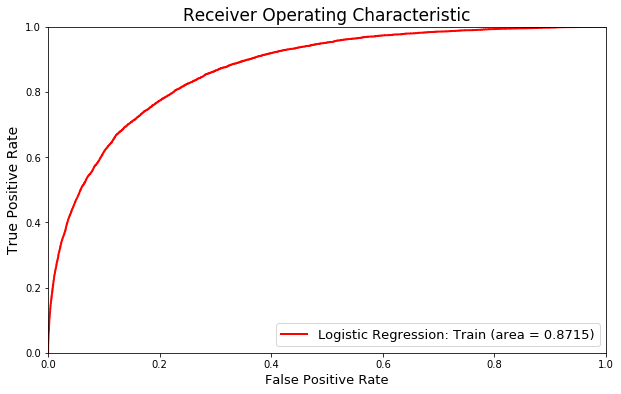

In [75]:
src.model_eval.evaluate_auc(logit, X, y, 'Logistic Regression: Train')

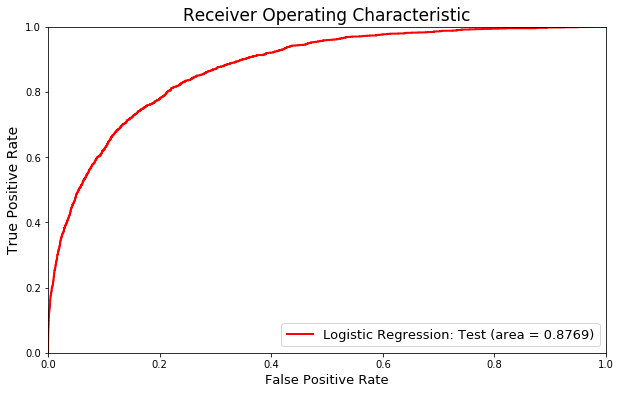

In [76]:
src.model_eval.evaluate_auc(logit, X_test, y_test, 'Logistic Regression: Test')

### Decision Tree

In [77]:
tree = DecisionTreeClassifier(max_depth=5, random_state=42)
tree.fit(X, y)

DecisionTreeClassifier(max_depth=5, random_state=42)

Results on the Training Data:

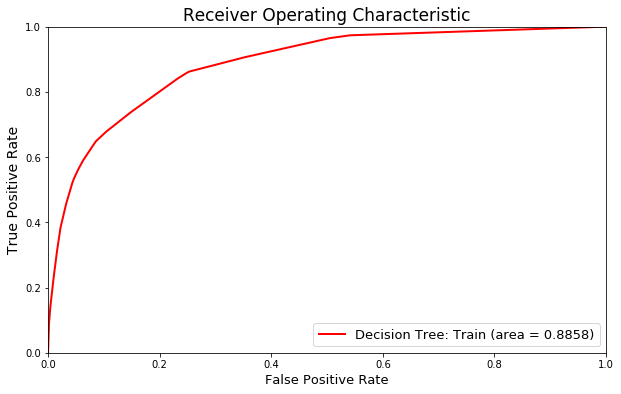

In [78]:
src.model_eval.evaluate_auc(tree, X, y, 'Decision Tree: Train')

Results on the Test Data:

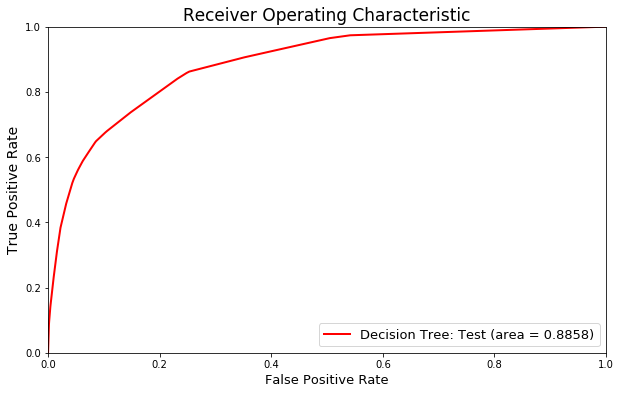

In [79]:
src.model_eval.evaluate_auc(tree, X, y, 'Decision Tree: Test')

**Identifying which features were the most impactful to the Decision Tree model:**

In [80]:
src.model_eval.get_feature_importance(X, tree.feature_importances_)

feature  importance
12                        d1_lactate_min    0.592667
9                             d1_inr_max    0.112754
1                            fio2_apache   0.0927306
11                        d1_lactate_max    0.029816
3                       gcs_motor_apache   0.0250667
19            apache_3j_diagnosis_102.01   0.0195514
13                    elective_surgery_2   0.0187222
14               apache_post_operative_2   0.0161787
2                        gcs_eyes_apache   0.0146381
17              diff_ventilated_apache_0   0.0121398
21              apache_2_diagnosis_121.0  0.00932037
15                   ventilated_apache_1  0.00756051
0                                    age   0.0073024
5                              ph_apache  0.00664191
16                   ventilated_apache_2  0.00658226
18  hospital_admit_source_Operating Room  0.00640663
4                            pao2_apache  0.00619401
7                            h1_temp_min  0.00382784
6                            d1_spo2_min  0.00371164
8                         d1_albumin_min  0.00318917
20     apache_3j_bodysystem_Neurological  0.00314668
10                            d1_inr_min  0.00185168

### Random Forest

In [81]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=150, max_depth=4, random_state=42)
forest.fit(X, y)

RandomForestClassifier(max_depth=4, n_estimators=150, random_state=42)

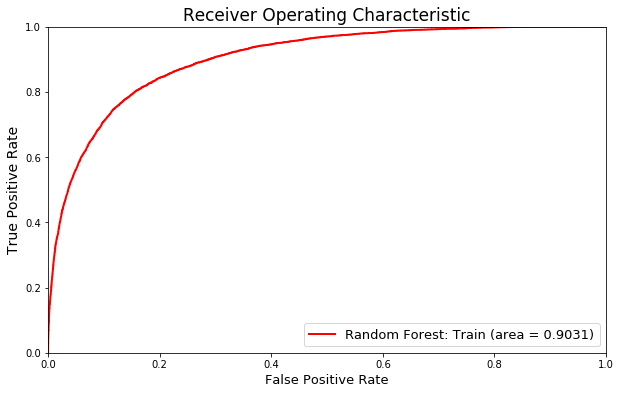

In [82]:
src.model_eval.evaluate_auc(forest, X, y, 'Random Forest: Train')

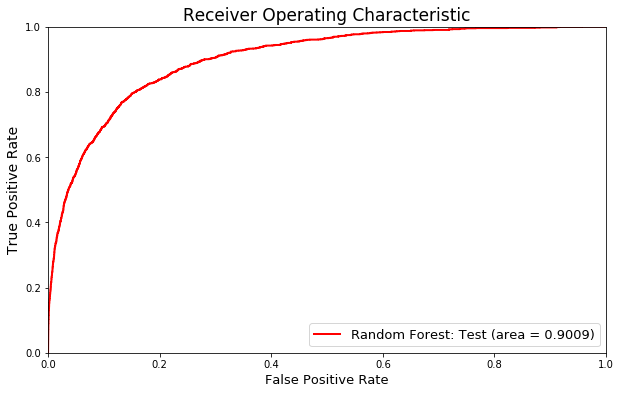

In [83]:
src.model_eval.evaluate_auc(forest, X_test, y_test, 'Random Forest: Test')

### XG Boost

In [84]:
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn import  metrics   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV

In [85]:
# Create X (predictors) and y (target). We are using unimputed data here
y = train[['hospital_death']]
X = train.drop(columns = ['hospital_death'])

y_test = test[['hospital_death']]
X_test = test.drop(columns = ['hospital_death'])

In [86]:
xgb = XGBClassifier(learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=4, gamma=0.25, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, reg_alpha=0.0001, seed=42)
xgb.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.25, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=4, missing=nan, monotone_constraints='()',
              n_estimators=177, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=42, reg_alpha=0.0001, reg_lambda=1,
              scale_pos_weight=1, seed=42, subsample=0.8, tree_method='exact',
              validate_parameters=1, verbosity=None)

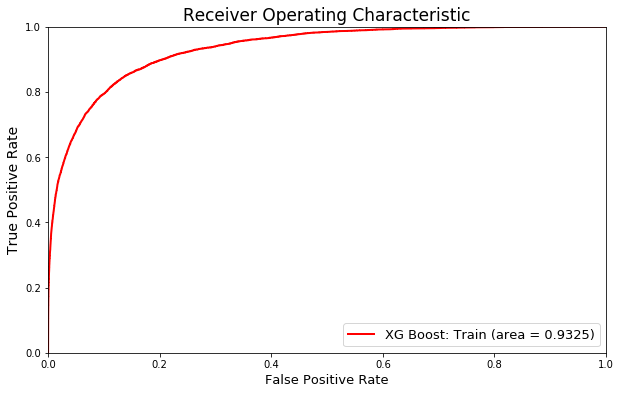

In [87]:
src.model_eval.evaluate_auc(xgb, X, y, 'XG Boost: Train')

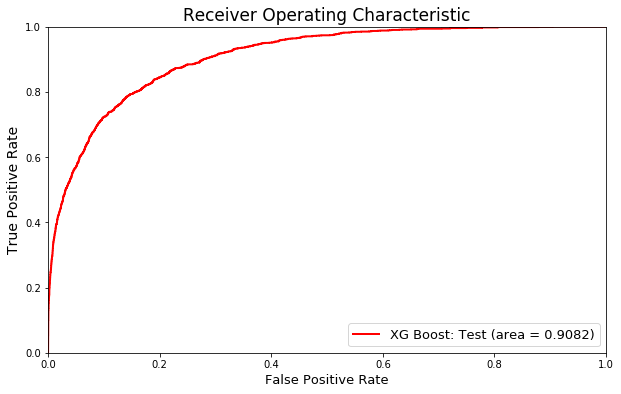

In [88]:
src.model_eval.evaluate_auc(xgb, X_test, y_test, 'XG Boost: Test')

### Light GBM

In [89]:
from lightgbm import LGBMClassifier

In [90]:
import lightgbm as lgb
d_train = lgb.Dataset(X, label=y)
params = {}
params['learning_rate'] = 0.1
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['sub_feature'] = 0.5
params['num_leaves'] = 10
params['min_data'] = 50
params['max_depth'] = 6
params['min_child_weight'] = 1
params['n_estimators'] = 350
clf = lgb.train(params, d_train, 350)

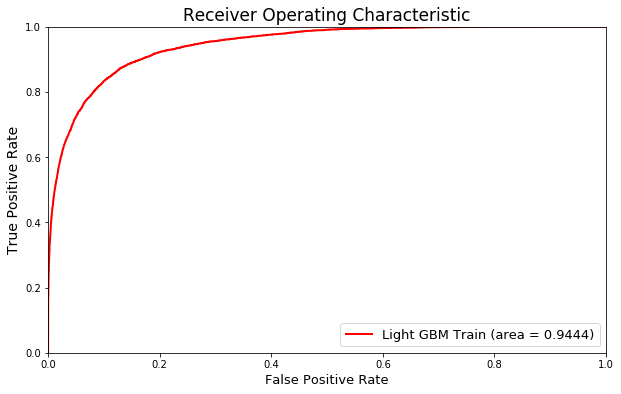

In [91]:
plt.figure(figsize=(10,6))

y_pred=clf.predict(X)
fpr, tpr, thresholds = roc_curve(y, y_pred)
plt.plot(fpr, tpr, color='red', lw=2, label='Light GBM Train (area = %0.4f)' % auc(fpr, tpr))
         
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle= '-', label = 'Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic', fontsize=17)
plt.legend(loc='lower right', fontsize=13)
plt.show()

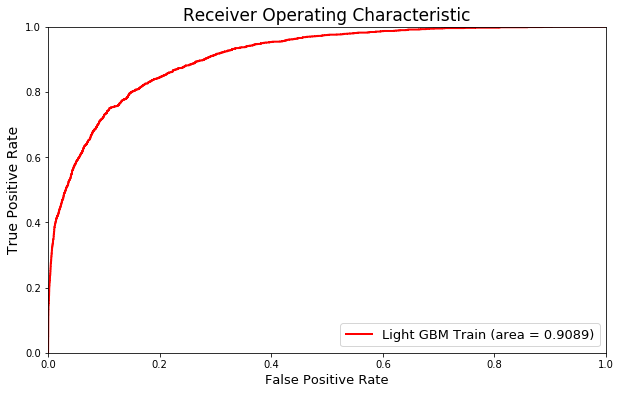

In [92]:
plt.figure(figsize=(10,6))

y_pred=clf.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color='red', lw=2, label='Light GBM Train (area = %0.4f)' % auc(fpr, tpr))
         
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle= '-', label = 'Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic', fontsize=17)
plt.legend(loc='lower right', fontsize=13)
plt.show()

# Conclusion

Our project gave us insight into indentifying two key patient groups: patients who are at high risk of dying, and __patients who were at a low risk of dying yet still succumbed to their injuries__.

Let's use the best performing model, our __light GBM model__ to look at some examples of these two groups:

In [93]:
# Applying our Light GBM Model to our data
final_data = X
final_data['predicted_survival'] = clf.predict(X)
final_data['actual_patient_outcome'] = y

In [94]:
final_results = final_data[['actual_patient_outcome', 'predicted_survival']]

We'll be using final_results to look at a comparison between the actual patient outcome, and what our model predicted.
>__Keep in mind that the close to 1 for the prediction, the model predicted the patient was more likely not to survive__

## High Risk Patients 

In [95]:
above_80 = final_results.predicted_survival > .8
survived = final_results.actual_patient_outcome == 0
did_not_survive = final_results.actual_patient_outcome == 1

In [96]:
len(final_results[above_80]) / len(final_results)

0.015428649311707782

1 Percent of the patients in our data were predicted to have above an 80 percent chance of dying. Let's see how accurate the model was at predicting the outcomes for those it predicted above 80%:

In [97]:
len(final_results[above_80 & did_not_survive]) / len(final_results[above_80])

0.9770318021201413

So our model does a pretty good job of identifying high risk patients and accurately predicting they are unlikely to survive. __But what about those cases where the patient survived?__

In [98]:
len(final_results[above_80 & survived]) / len(final_results[above_80])

0.022968197879858657

## Patients With Low Probability of Dying who Didn't Survive

In [99]:
below_30 = final_results.predicted_survival < .3

In [100]:
len(final_results[below_30]) / len(final_results)

0.918413520512471

91% of the patients were predicted to have a low risk of dying in the ICU. Let's see how many of those patients actually did not survive:

In [101]:
len(final_results[below_30 & did_not_survive]) / len(final_results[below_30])

0.03399916894218212

In [102]:
# Number of patients assessed to have less than a 30% chance of dying who did not survive
len(final_results[below_30 & did_not_survive])

2291